In [1]:
import os
import sys
import casadi as cd
sys.path.append(os.path.abspath(os.path.dirname(os.getcwd())))
sys.path.append(os.path.abspath(os.getcwd()))
from Envs.pendulum import Pendulum_Env,Pendulum_Model
from Solvers.OCsolver import ocsolver_v2
from Solvers.Cutter import cutter_v2
from Solvers.MVEsolver import mvesolver
from utils.Correction import Correction_Agent
import numpy as np
from matplotlib import pyplot as plt
import time

In [2]:
def pendulum_eval():
    # get dynamics, set up step cost and terminal cost
    #0.05
    p_model=Pendulum_Model(10,1,1,0.4,0.02)

    P_matrix=np.array([[0.0,0],
                   [0,0.0]])
    T_matrix=np.array([[25,0],
                   [0,10]])



    dyn_func=p_model.get_dyn_f()
    step_func=p_model.get_step_cost(P_matrix,0.1)
    terminal_func=p_model.get_terminal_cost(T_matrix)

    # set up safety features
    Horizon=40
    Gamma=0.1
    def generate_phi():
            traj=cd.SX.sym('xi',3*Horizon + 2)
            phi=cd.vertcat(cd.DM(-3),traj[3:5])
            return cd.Function('phi',[traj],[phi])

    phi_func=generate_phi() #traj: [x,u,x,u,..,x] phi:[phi0, phi1, phi2]

    lbs=np.array([-2,-2]) #-6
    ubs=np.array([2,2])

    weights_init=(lbs+ubs)/2
    weights_H=np.array([0.6,1])

    #construct environment
    p_env=Pendulum_Env(10,1,1,0.4,0.02)
    p_env.set_init_state(np.array([0,0]))
    #p_env.set_noise(False)
    #construct correction agent
    agent=Correction_Agent('dummy')
    agent.set_state_dim(2)
    agent.set_ctrl_dim(1)
    agent.set_dyn(dyn_func)
    agent.set_step_cost(step_func)
    agent.set_term_cost(terminal_func)
    agent.set_g(phi_func,weights=weights_H,gamma=Gamma)
    #agent.set_threshold(-0.1) #-0.5
    agent.set_threshold(-0.25) #-0.5
    agent.set_p(0.3)
    agent.construct_graph(horizon=Horizon)

    #construct controller
    controller=ocsolver_v2('pendulum control')
    controller.set_state_param(2,[-2*np.pi,-100],[2*np.pi,100])
    controller.set_ctrl_param(1,[-1e10],[1e10])
    controller.set_dyn(dyn_func)
    controller.set_step_cost(step_func)
    controller.set_term_cost(terminal_func)
    #controller.construct_graph(horizon=Horizon)
    controller.set_g(phi_func,gamma=Gamma)
    controller.construct_prob(horizon=Horizon)

    #construct cutter
    hb_calculator=cutter_v2('pendulum cut')
    hb_calculator.from_controller(controller)
    hb_calculator.construct_graph(horizon=Horizon)

    #construct MVESolver
    mve_calc=mvesolver('pendulum_mve',2)

    mve_calc.set_init_constraint(lbs, ubs) #Theta_0

    learned_theta=np.random.uniform(lbs,ubs)

    #learning logs
    theta_log=[np.array(learned_theta)]
    error_log=[np.linalg.norm(learned_theta-weights_H)]

    d_0,C_0=mve_calc.solve()
    v_0=np.log(np.linalg.det(C_0))
    volume_log=[v_0]

    EPISODE=0
    corr_num=0
    termination_flag=False
    success=False

    while not termination_flag:
        #print('episode',EPISODE)
        # random init
        init_state=np.array([0.,0.])
        init_state[0] += np.random.uniform(0,2*np.pi/3)
        init_state[1] += np.random.uniform(0,3)
        if np.dot(np.array([-3,init_state[0],init_state[1]]), np.array([1,learned_theta[0],learned_theta[1]]))>0:
            continue
        p_env.set_init_state(init_state)
        for i in range(200):
            x=p_env.get_curr_state()
            if np.sqrt(np.sum((x-np.array([np.pi,0]))**2)) <=0.15:
                print('reached desired position')
                break
            #print(i)
            u=controller.control(x,weights=learned_theta)
            agent_output=agent.act(controller.opt_traj)
            if agent_output is None:
                #print('emergency stop')
                break
            elif type(agent_output)==bool:
                pass
            else:
                corr_num+=1
                st=time.time()
                h,b,h_phi,b_phi=hb_calculator.calc_planes(learned_theta,x,controller.opt_traj,np.sign(agent_output))
                #print('cutting plane calculated')
                print('h',h)
                print('b',b)
                #print('diff', h.T @ learned_theta - b)
                #print('h_phi',h_phi)
                #print('b_phi',b_phi)

                mve_calc.add_constraint(h,b[0])
                mve_calc.add_constraint(h_phi,b_phi[0])
                center,C=mve_calc.solve()

                A,B = mve_calc.get_constraints()
                sample = np.random.uniform(-2,2,(2,1))
                while not np.all(A @ sample < B):
                    sample = np.random.uniform(-2,2,(2,1))
                
                print('sample',sample)
                learned_theta = sample.flatten()
                print('learning time', time.time()-st)

                #difference=np.linalg.norm(learned_theta-weights_H)
                difference=learned_theta-weights_H
                print('difference', difference)
                vol=np.log(np.linalg.det(C))
                #print('leanred safety param',learned_theta)
                theta_log.append(learned_theta)
                #print('difference', difference)
                error_log.append(np.linalg.norm(difference))
                #print('volume', vol)
                volume_log.append(vol)
                #mve_calc.draw(C,learned_theta,weights_H)
                #if np.max(np.abs(difference))<0.04:
                if np.linalg.norm(difference) < 0.02:
                    print("converged! Final Result: ",learned_theta)
                    termination_flag=True
                    success=True
                    break
                
                
            p_env.step(u)
        #p_env.show_animation()
        EPISODE+=1
        if EPISODE>40:
            termination_flag=True
            success=False

    return theta_log, error_log, volume_log,success

In [3]:
theta_logs=[]
error_logs=[]
volume_logs=[]
lengths = []

In [4]:
eval_cnt=0
while eval_cnt<50:
    print('eval num',eval_cnt)
    try:
        tmp_theta_log,tmp_error_log,tmp_volume_log,success=pendulum_eval()

        if not success:
            continue

        print('length',len(tmp_theta_log))
        lengths.append(len(tmp_theta_log))
        theta_logs.append(tmp_theta_log)
        error_logs.append(tmp_error_log)
        volume_logs.append(tmp_volume_log)
        eval_cnt+=1
    except:
        print("error")

eval num 0
h [0.553002, 0.825604]
b 1.24604
sample [[-0.91900258]
 [ 0.09945992]]
learning time 0.023578405380249023
difference [-1.51900258 -0.90054008]


CasADi - 2024-12-06 09:42:51 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:42:51 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


h [-0.000282875, -0.00617447]
b -0.000354152
sample [[-1.69843967]
 [ 1.89907109]]
learning time 0.016553878784179688
difference [-2.29843967  0.89907109]
h [-0.00591972, -0.0088936]
b -0.00683529
sample [[0.31255568]
 [0.75751361]]
learning time 0.01871013641357422
difference [-0.28744432 -0.24248639]
h [-0.00945154, -0.0103902]
b -0.0108249
sample [[0.69729305]
 [0.54587684]]
learning time 0.019933223724365234
difference [ 0.09729305 -0.45412316]
reached desired position
h [-0.00106814, -0.0120954]
b -0.0073474
sample [[0.22279109]
 [1.08809101]]
learning time 0.02175116539001465
difference [-0.37720891  0.08809101]
h [0.382262, 1.68323]
b 1.91667
sample [[0.17106482]
 [0.95674898]]
learning time 0.023736000061035156
difference [-0.42893518 -0.04325102]


CasADi - 2024-12-06 09:42:51 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:42:51 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


h [-0.0117338, -0.0210302]
b -0.0221279
sample [[0.62540829]
 [0.76021266]]
learning time 0.023941516876220703
difference [ 0.02540829 -0.23978734]
h [-0.0192009, -0.0201703]
b -0.0273421
sample [[0.58261688]
 [0.95219707]]
learning time 0.02437591552734375
difference [-0.01738312 -0.04780293]
h [-0.102478, -0.0806853]
b -0.136533
sample [[0.74831877]
 [0.77923466]]
learning time 0.051438093185424805
difference [ 0.14831877 -0.22076534]
h [0.195517, 0.123479]
b 0.242529
sample [[0.6718752 ]
 [0.89347795]]
learning time 0.027968645095825195
difference [ 0.0718752  -0.10652205]
h [0.118556, 0.0692648]
b 0.141541
sample [[0.57695635]
 [0.96423948]]
learning time 0.029268503189086914
difference [-0.02304365 -0.03576052]
h [-0.053784, -0.0337259]
b -0.0635509
sample [[0.62650749]
 [0.90778316]]
learning time 0.03220415115356445
difference [ 0.02650749 -0.09221684]
h [-0.0563742, -0.0329954]
b -0.0652716
sample [[0.66190576]
 [0.85302052]]
learning time 0.03525996208190918
difference [ 0.061

CasADi - 2024-12-06 09:42:52 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:42:52 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


sample [[0.60571902]
 [0.99273327]]
learning time 0.05394411087036133
difference [ 0.00571902 -0.00726673]
converged! Final Result:  [0.60571902 0.99273327]
length 17
eval num 1
h [1.23542e-05, -0.00597252]
b 3.74556e-05
sample [[-0.51621123]
 [ 0.32658805]]
learning time 0.014876604080200195
difference [-1.11621123 -0.67341195]
h [-0.000733434, -0.00767391]
b -0.0021276
sample [[0.95597333]
 [0.44328246]]
learning time 0.015966176986694336
difference [ 0.35597333 -0.55671754]
h [-0.00140356, -0.010762]
b -0.00611237
sample [[-1.84776593]
 [ 1.48995191]]
learning time 0.018314599990844727
difference [-2.44776593  0.48995191]
h [0.208666, 1.10777]
b 1.26495
sample [[-0.37536445]
 [ 0.79141121]]
learning time 0.019173383712768555
difference [-0.97536445 -0.20858879]
h [-0.00382397, -0.00931148]
b -0.00593383
sample [[0.88676215]
 [0.45727032]]
learning time 0.02113819122314453
difference [ 0.28676215 -0.54272968]
h [-0.0132732, -0.0178848]
b -0.0199483
sample [[0.77271392]
 [0.62254119]]

CasADi - 2024-12-06 09:42:53 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:42:53 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


h [-0.0127657, -0.0183593]
b -0.0212937
sample [[0.1546186 ]
 [1.07112034]]
learning time 0.024238109588623047
difference [-0.4453814   0.07112034]
h [-0.0154112, -0.0213054]
b -0.0252035
sample [[0.50816825]
 [0.95416842]]
learning time 0.024284839630126953
difference [-0.09183175 -0.04583158]
h [-0.0318684, -0.0352109]
b -0.0497916
sample [[0.49055477]
 [1.02227089]]
learning time 0.026099205017089844
difference [-0.10944523  0.02227089]
h [-0.0653006, -0.0664001]
b -0.0999124
sample [[0.57315572]
 [1.01118978]]
learning time 0.028799057006835938
difference [-0.02684428  0.01118978]
h [-0.0719439, -0.0574802]
b -0.0993584
sample [[0.76480081]
 [0.78401024]]
learning time 0.03019857406616211
difference [ 0.16480081 -0.21598976]
h [0.173287, 0.127324]
b 0.232354
sample [[0.73373972]
 [0.8251021 ]]
learning time 0.03182482719421387
difference [ 0.13373972 -0.1748979 ]
h [0.152352, 0.0885382]
b 0.18484
sample [[0.62865699]
 [0.95428852]]
learning time 0.03253650665283203
difference [ 0.0

CasADi - 2024-12-06 09:42:55 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:42:55 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


h [-0.0107292, -0.0264023]
b -0.0277923
sample [[0.72741968]
 [0.86100822]]
learning time 0.022848844528198242
difference [ 0.12741968 -0.13899178]
h [-0.0254161, -0.0539233]
b -0.0649165
sample [[0.62504921]
 [0.93136158]]
learning time 0.03144502639770508
difference [ 0.02504921 -0.06863842]
h [-0.0710098, -0.0547729]
b -0.095398
sample [[0.59775389]
 [0.99934933]]
learning time 0.038245439529418945
difference [-0.00224611 -0.00065067]
converged! Final Result:  [0.59775389 0.99934933]
length 9
eval num 3
h [-0.000832551, -0.0067051]
b -0.00128267
sample [[-0.31151672]
 [ 1.55535231]]
learning time 0.014936447143554688
difference [-0.91151672  0.55535231]
h [-0.0162075, -0.0172981]
b -0.0218558
sample [[0.84629299]
 [0.67563681]]
learning time 0.01597142219543457
difference [ 0.24629299 -0.32436319]
h [0.279489, 0.177793]
b 0.356653
sample [[0.5862942 ]
 [1.02636466]]
learning time 0.017002105712890625
difference [-0.0137058   0.02636466]
h [0.108003, 0.0678274]
b 0.132937
sample [[0.

CasADi - 2024-12-06 09:42:56 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


h [-0.0849403, -0.0519634]
b -0.101328
sample [[0.74426783]
 [0.77197902]]
learning time 0.038123369216918945
difference [ 0.14426783 -0.22802098]
h [0.129032, 0.072752]
b 0.152197
sample [[0.70128014]
 [0.83888417]]
learning time 0.04059243202209473
difference [ 0.10128014 -0.16111583]
reached desired position
h [-0.0997233, -0.0651463]
b -0.124584
sample [[0.56784173]
 [1.05429985]]
learning time 0.05904364585876465
difference [-0.03215827  0.05429985]
h [0.0922107, 0.057158]
b 0.112623
sample [[0.51202699]
 [1.13949149]]
learning time 0.057286977767944336
difference [-0.08797301  0.13949149]
h [-0.0786719, -0.0472034]
b -0.09407
sample [[0.63939194]
 [0.93443336]]
learning time 0.11197662353515625
difference [ 0.03939194 -0.06556664]
h [0.0782212, 0.0453943]
b 0.092432
sample [[0.54964405]
 [1.07698544]]
learning time 0.08375763893127441
difference [-0.05035595  0.07698544]
h [-0.0602518, -0.0339047]
b -0.0696319
sample [[0.55408484]
 [1.07253632]]
learning time 0.07641029357910156


CasADi - 2024-12-06 09:42:57 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:42:57 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


sample [[0.59948638]
 [0.99559465]]
learning time 0.05712628364562988
difference [-0.00051362 -0.00440535]
converged! Final Result:  [0.59948638 0.99559465]
length 24
eval num 4


CasADi - 2024-12-06 09:42:57 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:42:57 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:42:58 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:42:58 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:42:58 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:42:58 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:42:58 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

reached desired position


CasADi - 2024-12-06 09:43:00 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:00 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:00 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:01 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:01 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:01 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:01 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

reached desired position


CasADi - 2024-12-06 09:43:02 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:02 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:02 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:02 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:02 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:02 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:02 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

reached desired position


CasADi - 2024-12-06 09:43:06 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:06 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:07 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:07 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:07 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:07 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:07 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

reached desired position


CasADi - 2024-12-06 09:43:08 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:08 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:08 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:08 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:08 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:08 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:08 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

reached desired position


CasADi - 2024-12-06 09:43:10 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:10 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:10 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:11 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:11 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:11 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:11 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

reached desired position


CasADi - 2024-12-06 09:43:13 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:13 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:13 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:13 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:13 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:13 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:14 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

reached desired position


CasADi - 2024-12-06 09:43:15 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:15 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:15 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:15 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:15 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:15 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:15 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

reached desired position


CasADi - 2024-12-06 09:43:16 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:16 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:16 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:16 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:16 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:16 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:16 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

reached desired position


CasADi - 2024-12-06 09:43:17 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:17 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:17 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:17 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:17 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:17 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:17 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

reached desired position


CasADi - 2024-12-06 09:43:20 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:21 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:21 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:21 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:21 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:22 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:22 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

reached desired position


CasADi - 2024-12-06 09:43:26 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:26 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:26 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:26 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:26 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:26 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


reached desired position


CasADi - 2024-12-06 09:43:27 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:27 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:27 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:27 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


eval num 4
h [-0.00505276, -0.0147892]
b -0.0126042
sample [[1.13319161]
 [0.57398548]]
learning time 0.014800310134887695
difference [ 0.53319161 -0.42601452]
h [-0.013919, -0.0309773]
b -0.0335534
sample [[0.19091831]
 [1.03515095]]
learning time 0.016167402267456055
difference [-0.40908169  0.03515095]
h [-0.0181058, -0.127611]
b -0.135554
sample [[0.04111386]
 [1.08858736]]
learning time 0.01843118667602539
difference [-0.55888614  0.08858736]
h [-0.220766, -1.33125]
b -1.45826
sample [[0.33408611]
 [1.04009601]]
learning time 0.023262739181518555
difference [-0.26591389  0.04009601]


CasADi - 2024-12-06 09:43:28 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


h [-0.0206959, -0.0192438]
b -0.0269296
sample [[0.38936506]
 [1.03225924]]
learning time 0.02506852149963379
difference [-0.21063494  0.03225924]
h [-0.0257889, -0.0224116]
b -0.0331759
sample [[0.53998462]
 [1.00700079]]
learning time 0.040418148040771484
difference [-0.06001538  0.00700079]
h [-0.0620948, -0.0448048]
b -0.0786487
sample [[0.57771353]
 [1.00210301]]
learning time 0.179412841796875
difference [-0.02228647  0.00210301]
h [-0.0922729, -0.0607221]
b -0.114157
sample [[0.61522714]
 [0.99604983]]
learning time 0.6367151737213135
difference [ 0.01522714 -0.00395017]
converged! Final Result:  [0.61522714 0.99604983]
length 9
eval num 5
h [-5.65842e-05, -0.0060924]
b -0.000130994
sample [[0.5126483 ]
 [0.21273012]]
learning time 0.015387296676635742
difference [-0.0873517  -0.78726988]
h [-0.000749792, -0.00749677]
b -0.00197917
sample [[0.95899792]
 [0.63521795]]
learning time 0.01717400550842285
difference [ 0.35899792 -0.36478205]
h [-0.0171465, -0.0258719]
b -0.0328778
sa

CasADi - 2024-12-06 09:43:29 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:29 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:29 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:29 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


h [-0.00208084, -0.0114479]
b -0.00685742
sample [[0.6240042 ]
 [0.93199868]]
learning time 0.020846128463745117
difference [ 0.0240042  -0.06800132]
h [-0.0331482, -0.095368]
b -0.109567
sample [[0.22790838]
 [1.13377381]]
learning time 0.023572683334350586
difference [-0.37209162  0.13377381]
h [-0.0220299, -0.0251833]
b -0.0335729
sample [[0.64059983]
 [0.93298413]]
learning time 0.024440765380859375
difference [ 0.04059983 -0.06701587]
h [-0.293711, -0.254162]
b -0.42528
sample [[0.61336959]
 [0.97573271]]
learning time 0.045778751373291016
difference [ 0.01336959 -0.02426729]
h [-0.367656, -0.288738]
b -0.50724
sample [[0.63977233]
 [0.94499575]]
learning time 0.0847477912902832
difference [ 0.03977233 -0.05500425]
h [-0.375456, -0.285705]
b -0.510197
sample [[0.60779842]
 [0.9875958 ]]
learning time 0.07490968704223633
difference [ 0.00779842 -0.0124042 ]
converged! Final Result:  [0.60779842 0.9875958 ]
length 11
eval num 6
h [0.00146082, -0.00331679]
b 0.00385288
sample [[-0.59

CasADi - 2024-12-06 09:43:31 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:31 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:31 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:31 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:31 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


sample [[0.68301725]
 [0.99696978]]
learning time 0.017076730728149414
difference [ 0.08301725 -0.00303022]
h [0.680252, 1.40581]
b 1.86617
sample [[-0.52870433]
 [ 1.44951277]]
learning time 0.019328832626342773
difference [-1.12870433  0.44951277]
h [-0.0175589, -0.033785]
b -0.0396883
sample [[-0.42105307]
 [ 1.43962067]]
learning time 0.020003318786621094
difference [-1.02105307  0.43962067]
h [-0.0233604, -0.0498746]
b -0.0619645
sample [[-0.15808487]
 [ 1.31746112]]
learning time 0.02178168296813965
difference [-0.75808487  0.31746112]
h [-0.037409, -0.0847842]
b -0.105786
sample [[0.63081523]
 [1.00094021]]
learning time 0.02376103401184082
difference [0.03081523 0.00094021]
h [0.729458, 1.23495]
b 1.69626
sample [[-0.20972651]
 [ 1.36961181]]
learning time 0.026239395141601562
difference [-0.80972651  0.36961181]
h [0.455745, 1.27442]
b 1.64988
sample [[-0.09544271]
 [ 1.3077171 ]]
learning time 0.026105880737304688
difference [-0.69544271  0.3077171 ]
h [0.422545, 1.3111]
b 1.

CasADi - 2024-12-06 09:43:31 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:31 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:31 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:31 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:31 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:31 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:31 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

h [0.400553, 1.55772]
b 1.86821
sample [[0.28054882]
 [1.12658074]]
learning time 0.03002333641052246
difference [-0.31945118  0.12658074]
h [0.500747, 1.46639]
b 1.79249
sample [[0.51278619]
 [1.0312745 ]]
learning time 0.035308122634887695
difference [-0.08721381  0.0312745 ]
h [-0.436454, -1.216]
b -1.47784
sample [[0.53334741]
 [1.02886796]]
learning time 0.045369863510131836
difference [-0.06665259  0.02886796]
h [0.585523, 1.42119]
b 1.7745
sample [[0.47870302]
 [1.04396533]]
learning time 0.0420231819152832
difference [-0.12129698  0.04396533]
h [-0.0750223, -0.0786261]
b -0.117996
sample [[0.4815299 ]
 [1.04461173]]
learning time 0.26575565338134766
difference [-0.1184701   0.04461173]
h [0.0526879, 0.601517]
b 0.653722


CasADi - 2024-12-06 09:43:32 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:32 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:32 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:32 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:32 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


sample [[0.54106815]
 [1.02204085]]
learning time 0.17981243133544922
difference [-0.05893185  0.02204085]
h [0.416657, 1.7229]
b 1.98631
error
eval num 7
h [0.000439915, -0.0057046]
b 0.000590108
sample [[0.25065901]
 [1.49470101]]
learning time 0.014627218246459961
difference [-0.34934099  0.49470101]
h [-0.0966312, -0.0642362]
b -0.120235
sample [[0.13729383]
 [1.72751551]]
learning time 0.016011714935302734
difference [-0.46270617  0.72751551]
h [-0.120543, -0.0761497]
b -0.1481
sample [[1.02909693]
 [0.3351905 ]]
learning time 0.017402172088623047
difference [ 0.42909693 -0.6648095 ]
h [0.585852, 0.321541]
b 0.710676
sample [[0.44375849]
 [1.26634203]]
learning time 0.019812822341918945
difference [-0.15624151  0.26634203]
h [-0.0650691, -0.037712]
b -0.0766312
sample [[0.41416916]
 [1.37633644]]
learning time 0.020867586135864258
difference [-0.18583084  0.37633644]
h [0.0792503, 0.0433643]
b 0.092507
sample [[0.6200548 ]
 [0.98302824]]
learning time 0.023927688598632812
differen

CasADi - 2024-12-06 09:43:33 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:33 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:33 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:33 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


sample [[0.61081728]
 [0.98061876]]
learning time 0.054180145263671875
difference [ 0.01081728 -0.01938124]
h [-0.148976, -0.162536]
b -0.250383


CasADi - 2024-12-06 09:43:34 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:34 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:34 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:34 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


sample [[0.60209103]
 [0.99598306]]
learning time 0.066162109375
difference [ 0.00209103 -0.00401694]
converged! Final Result:  [0.60209103 0.99598306]
length 13
eval num 9
h [0.00131276, -0.00232674]
b 0.0048621
sample [[-0.90119304]
 [-0.67788438]]
learning time 0.014418601989746094
difference [-1.50119304 -1.67788438]
h [0.00156238, -0.00497859]
b 0.0019669
sample [[-1.04819851]
 [-0.36490732]]
learning time 0.01591634750366211
difference [-1.64819851 -1.36490732]
h [0.000908465, -0.00552257]
b 0.00106297
sample [[0.25782113]
 [0.37183614]]
learning time 0.01735711097717285
difference [-0.34217887 -0.62816386]
reached desired position
h [-0.00248013, -0.00793744]
b -0.00359086
sample [[-0.19762779]
 [ 0.68294732]]
learning time 0.019774675369262695
difference [-0.79762779 -0.31705268]
h [-0.00333934, -0.00912314]
b -0.00557068
sample [[-1.56633445]
 [ 1.59058559]]
learning time 0.020934581756591797
difference [-2.16633445  0.59058559]
h [-0.0148155, -0.0465166]
b -0.0507826
sample [

CasADi - 2024-12-06 09:43:34 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:35 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:35 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:35 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:35 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


sample [[0.58610488]
 [1.01945731]]
learning time 0.0268709659576416
difference [-0.01389512  0.01945731]
h [0.677663, 0.856983]
b 1.27084
sample [[0.53449077]
 [1.00471353]]
learning time 0.028641700744628906
difference [-0.06550923  0.00471353]


CasADi - 2024-12-06 09:43:35 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:35 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:35 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:35 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:35 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


h [-0.0210255, -0.0632722]
b -0.0748084
sample [[0.49619877]
 [1.04925897]]
learning time 0.02996516227722168
difference [-0.10380123  0.04925897]
h [0.648594, 1.40042]
b 1.79123
sample [[0.50401728]
 [1.02517385]]
learning time 0.029680490493774414
difference [-0.09598272  0.02517385]
h [0.426226, 1.78091]
b 2.04057


CasADi - 2024-12-06 09:43:35 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:35 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:35 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:35 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:35 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:35 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


sample [[0.5051488]
 [1.0175345]]
learning time 0.12694811820983887
difference [-0.0948512  0.0175345]
h [-0.0322684, -0.0316159]
b -0.0484706
sample [[0.53446104]
 [1.01775941]]
learning time 0.10495853424072266
difference [-0.06553896  0.01775941]


CasADi - 2024-12-06 09:43:36 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


h [-0.211961, -0.608355]
b -0.732444
sample [[0.6008704 ]
 [0.99894549]]
learning time 0.08200287818908691
difference [ 0.0008704  -0.00105451]
converged! Final Result:  [0.6008704  0.99894549]
length 15
eval num 10
h [1.73074e-05, -0.00594565]
b 6.5575e-05
sample [[-1.85908486]
 [ 1.47761505]]
learning time 0.015422582626342773
difference [-2.45908486  0.47761505]
h [-0.00447319, -0.0109542]
b -0.00786999
sample [[-1.66871284]
 [ 1.70091738]]
learning time 0.01689291000366211
difference [-2.26871284  0.70091738]
h [0.308201, 1.09559]
b 1.34921
sample [[0.32891691]
 [0.59600379]]
learning time 0.017555952072143555
difference [-0.27108309 -0.40399621]


CasADi - 2024-12-06 09:43:36 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


h [-0.00565822, -0.010437]
b -0.00808155
sample [[0.96405371]
 [0.49832038]]
learning time 0.019338130950927734
difference [ 0.36405371 -0.50167962]
h [0.463881, 0.317286]
b 0.605317
sample [[-0.03398188]
 [ 0.86904302]]
learning time 0.02016139030456543
difference [-0.63398188 -0.13095698]
h [-0.00710144, -0.0102357]
b -0.00865398
sample [[0.02313332]
 [1.14194129]]
learning time 0.02184295654296875
difference [-0.57686668  0.14194129]
h [-0.0116799, -0.0114205]
b -0.0133117
sample [[0.62532584]
 [0.84258167]]
learning time 0.023797988891601562
difference [ 0.02532584 -0.15741833]
h [-0.0384233, -0.0229985]
b -0.0434052
sample [[0.79195235]
 [0.58555627]]
learning time 0.024590730667114258
difference [ 0.19195235 -0.41444373]
reached desired position
h [-0.00904481, -0.0154294]
b -0.0161978
sample [[0.65027476]
 [0.93107848]]
learning time 0.026065826416015625
difference [ 0.05027476 -0.06892152]
h [-0.01655, -0.0648459]
b -0.0711387


CasADi - 2024-12-06 09:43:36 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:36 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:37 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:37 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


sample [[0.5866547 ]
 [0.99415473]]
learning time 0.028535127639770508
difference [-0.0133453  -0.00584527]
converged! Final Result:  [0.5866547  0.99415473]
length 11
eval num 11
h [0.395995, 1.06161]
b 1.40826
sample [[ 1.91463323]
 [-1.14474833]]
learning time 0.014550447463989258
difference [ 1.31463323 -2.14474833]
h [0.0130992, 0.00462307]
b 0.0197879
sample [[ 0.76813663]
 [-0.49500746]]
learning time 0.016294479370117188
difference [ 0.16813663 -1.49500746]
h [0.00141477, -0.00401618]
b 0.00307478
sample [[-0.67090913]
 [-0.09617365]]
learning time 0.017506122589111328
difference [-1.27090913 -1.09617365]
h [0.000240735, -0.00577107]
b 0.000393511
sample [[0.04056488]
 [0.29174712]]
learning time 0.018738508224487305
difference [-0.55943512 -0.70825288]
h [-0.000352948, -0.00797551]
b -0.00234115
sample [[-1.28168709]
 [ 1.227861  ]]
learning time 0.020647764205932617
difference [-1.88168709  0.227861  ]
h [-0.00431738, -0.0108022]
b -0.00773002


CasADi - 2024-12-06 09:43:37 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:37 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


sample [[-0.04794705]
 [ 1.12896994]]
learning time 0.021831035614013672
difference [-0.64794705  0.12896994]
h [-0.0107823, -0.0166051]
b -0.0182297
sample [[1.00945029]
 [0.51058463]]
learning time 0.023194074630737305
difference [ 0.40945029 -0.48941537]
h [-0.00138917, -0.013247]
b -0.00816603
sample [[0.960569  ]
 [0.54285387]]
learning time 0.028772592544555664
difference [ 0.360569   -0.45714613]
h [0.0901354, 0.0624917]
b 0.120505
sample [[0.34675331]
 [0.97598607]]
learning time 0.026424407958984375
difference [-0.25324669 -0.02401393]
h [-0.0161788, -0.0161089]
b -0.0213321
sample [[0.52523523]
 [0.91532051]]
learning time 0.027865171432495117
difference [-0.07476477 -0.08467949]
h [-0.0264731, -0.0224854]
b -0.0344859
sample [[0.91762773]
 [0.52822358]]
learning time 0.029764890670776367
difference [ 0.31762773 -0.47177642]
h [0.277404, 0.15028]
b 0.333935
sample [[0.52491457]
 [0.99956755]]
learning time 0.03121018409729004
difference [-0.07508543 -0.00043245]
reached desir

CasADi - 2024-12-06 09:43:38 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:38 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:38 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:38 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:38 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


sample [[0.36736889]
 [1.1159263 ]]
learning time 0.019258499145507812
difference [-0.23263111  0.1159263 ]
h [-0.0353259, -0.0268119]
b -0.0428977
sample [[0.60122991]
 [0.8682554 ]]
learning time 0.020997047424316406
difference [ 0.00122991 -0.1317446 ]
h [-0.0440431, -0.0290633]
b -0.0517144
sample [[0.56568488]
 [0.97779067]]
learning time 0.02244091033935547
difference [-0.03431512 -0.02220933]
reached desired position
h [-0.0727604, -0.088044]
b -0.127248
sample [[0.44292554]
 [1.12137859]]
learning time 0.050147056579589844
difference [-0.15707446  0.12137859]
h [-0.0472166, -0.0457941]
b -0.072266
sample [[0.40893344]
 [1.18474255]]
learning time 0.025439977645874023
difference [-0.19106656  0.18474255]
h [-0.0891275, -0.0826275]
b -0.13434
sample [[0.60575544]
 [0.99235881]]
learning time 0.026152372360229492
difference [ 0.00575544 -0.00764119]
converged! Final Result:  [0.60575544 0.99235881]
length 10
eval num 12


CasADi - 2024-12-06 09:43:38 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:38 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:38 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:38 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:38 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:38 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:43:39 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

eval num 12


CasADi - 2024-12-06 09:44:10 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:44:10 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:44:10 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


h [-0.202629, -1.38361]
b -1.49982
sample [[1.4560992 ]
 [0.87257471]]
learning time 0.0211944580078125
difference [ 0.8560992  -0.12742529]
h [0.473177, 2.13184]
b 2.54919
sample [[-0.60660078]
 [ 1.17778785]]
learning time 0.018968582153320312
difference [-1.20660078  0.17778785]
h [-0.00725218, -0.0236128]
b -0.0234117
sample [[-0.35808704]
 [ 1.13796988]]
learning time 0.01967334747314453
difference [-0.95808704  0.13796988]
h [-0.00901264, -0.0464231]
b -0.0496008
sample [[0.63403455]
 [0.99176856]]
learning time 0.020302772521972656
difference [ 0.03403455 -0.00823144]
h [-0.0700693, -0.312739]
b -0.354591
sample [[0.66109489]
 [0.98970536]]
learning time 0.07077813148498535
difference [ 0.06109489 -0.01029464]
h [0.390938, 1.5735]
b 1.81574
sample [[0.64034223]
 [0.99047549]]
learning time 0.09039855003356934
difference [ 0.04034223 -0.00952451]
h [0.453768, 1.68057]
b 1.95513
error
eval num 12


CasADi - 2024-12-06 09:44:10 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:44:10 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:44:10 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:44:10 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


h [0.385632, 1.38989]
b 1.68464
sample [[ 0.06047148]
 [-1.52063881]]
learning time 0.014921903610229492
difference [-0.53952852 -2.52063881]
h [0.00334032, -0.00319937]
b 0.00506708
sample [[-0.99991681]
 [-0.76233714]]
learning time 0.01607036590576172
difference [-1.59991681 -1.76233714]
h [0.000442119, -0.00385328]
b 0.00249542
sample [[-1.60306165]
 [-0.78866894]]
learning time 0.017563343048095703
difference [-2.20306165 -1.78866894]
h [0.00134193, -0.00504828]
b 0.00183021
sample [[-0.6402607 ]
 [ 0.68797831]]
learning time 0.019337177276611328
difference [-1.2402607  -0.31202169]
h [-0.00280626, -0.00793155]
b -0.00366
sample [[-0.83280998]
 [ 0.81255324]]
learning time 0.020175457000732422
difference [-1.43280998 -0.18744676]
h [-0.0031036, -0.00809387]
b -0.00399199
sample [[-0.25372944]
 [ 0.86660782]]
learning time 0.021287202835083008
difference [-0.85372944 -0.13339218]
h [-0.00542286, -0.00917731]
b -0.00657719
sample [[-0.00134261]
 [ 1.01946784]]
learning time 0.022855

CasADi - 2024-12-06 09:44:13 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:44:13 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


h [0.116182, 0.333809]
b 0.412094
sample [[-1.42619518]
 [ 0.00867619]]
learning time 0.016225576400756836
difference [-2.02619518 -0.99132381]
h [-1.71842e-05, -0.00601602]
b -2.76907e-05
sample [[-0.64573061]
 [ 1.35725779]]
learning time 0.017085552215576172
difference [-1.24573061  0.35725779]
h [-0.0123349, -0.0333749]
b -0.0373333
sample [[-0.80869831]
 [ 1.45973103]]
learning time 0.019235849380493164
difference [-1.40869831  0.45973103]
h [-0.0222082, -0.0563723]
b -0.0643287
sample [[0.41953   ]
 [1.00879766]]
learning time 0.020938396453857422
difference [-0.18047     0.00879766]
h [-0.015512, -0.0470829]
b -0.0540049
sample [[0.59111558]
 [0.96826476]]
learning time 0.02244734764099121
difference [-0.00888442 -0.03173524]


CasADi - 2024-12-06 09:44:13 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:44:14 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:44:14 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:44:14 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:44:14 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:44:14 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


h [-0.0610733, -0.157702]
b -0.188799
sample [[0.48418899]
 [1.00969417]]
learning time 0.025393247604370117
difference [-0.11581101  0.00969417]
h [-0.0131092, -0.0868122]
b -0.0940011
sample [[0.31890621]
 [1.08223883]]
learning time 0.024936437606811523
difference [-0.28109379  0.08223883]
h [0.246781, 1.37831]
b 1.57036
sample [[0.44269817]
 [1.04006012]]
learning time 0.029958248138427734
difference [-0.15730183  0.04006012]


CasADi - 2024-12-06 09:44:14 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:44:14 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:44:14 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:44:14 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:44:14 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


h [0.00934063, 0.1182]
b 0.12707
sample [[0.57310144]
 [1.00376509]]
learning time 0.028737306594848633
difference [-0.02689856  0.00376509]
h [0.0546577, 0.551537]
b 0.584938
sample [[0.54847011]
 [1.00113425]]
learning time 0.0850226879119873
difference [-0.05152989  0.00113425]
h [-0.0631128, -0.0715631]
b -0.10626
sample [[0.61024324]
 [0.99732599]]
learning time 0.07638359069824219
difference [ 0.01024324 -0.00267401]
converged! Final Result:  [0.61024324 0.99732599]
length 13
eval num 15
h [0.00520443, -0.0018905]
b 0.00758878
sample [[-0.16929424]
 [-0.34059003]]
learning time 0.015416622161865234
difference [-0.76929424 -1.34059003]
h [0.000413445, -0.00476079]
b 0.00155148
sample [[-1.37334919]
 [ 0.10843841]]
learning time 0.016936779022216797
difference [-1.97334919 -0.89156159]
h [-0.000225324, -0.00622241]
b -0.000365302
sample [[-0.07679582]
 [ 0.8392942 ]]
learning time 0.017853260040283203
difference [-0.67679582 -0.1607058 ]
h [-0.00493261, -0.0130973]
b -0.0106137
sam

CasADi - 2024-12-06 09:44:14 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:44:15 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


h [0.243854, 1.33672]
b 1.56804
sample [[0.39427792]
 [1.0791062 ]]
learning time 0.02236485481262207
difference [-0.20572208  0.0791062 ]
h [0.45493, 1.57053]
b 1.87414
sample [[-0.06639875]
 [ 1.14237786]]
learning time 0.023220062255859375
difference [-0.66639875  0.14237786]
h [0.0222632, 0.143526]
b 0.162483
sample [[0.91796419]
 [0.5772842 ]]
learning time 0.02468252182006836
difference [ 0.31796419 -0.4227158 ]
h [-0.0026231, -0.0141179]
b -0.0105579
sample [[0.64069756]
 [0.77722028]]
learning time 0.028611421585083008
difference [ 0.04069756 -0.22277972]
h [-0.00654259, -0.0263129]
b -0.0246428
sample [[0.44396265]
 [0.96199709]]
learning time 0.029266357421875
difference [-0.15603735 -0.03800291]
h [-0.0145538, -0.0334098]
b -0.0386014
sample [[0.62792464]
 [0.89004444]]
learning time 0.029780149459838867
difference [ 0.02792464 -0.10995556]
h [-0.00598738, -0.0405721]
b -0.0398706
sample [[0.65147403]
 [0.89564891]]
learning time 0.031162261962890625
difference [ 0.05147403 

CasADi - 2024-12-06 09:44:16 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:44:16 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:44:16 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:44:16 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:44:16 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


sample [[0.63900294]
 [0.96611843]]
learning time 0.08170318603515625
difference [ 0.03900294 -0.03388157]
h [-0.275875, -0.441897]
b -0.60321
sample [[0.50076949]
 [1.06461319]]
learning time 0.041723012924194336
difference [-0.09923051  0.06461319]
h [-0.667171, -0.936682]
b -1.3313
sample [[0.51295301]
 [1.05818449]]
learning time 0.07461905479431152
difference [-0.08704699  0.05818449]
h [-0.0669869, -0.0584534]
b -0.0962156
sample [[0.54483281]
 [1.03886408]]
learning time 0.11616849899291992
difference [-0.05516719  0.03886408]
h [-0.164509, -0.130411]
b -0.225109
sample [[0.58499553]
 [1.00492604]]
learning time 0.031998395919799805
difference [-0.01500447  0.00492604]
converged! Final Result:  [0.58499553 1.00492604]
length 13
eval num 17
h [-0.000790736, -0.0101139]
b -0.00463994
sample [[1.0542625 ]
 [0.43771147]]
learning time 0.015170574188232422
difference [ 0.4542625  -0.56228853]
h [-0.0375978, -0.0403394]
b -0.057295
sample [[0.79992321]
 [0.77048108]]
learning time 0.0

CasADi - 2024-12-06 09:44:17 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:44:17 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


sample [[0.59553346]
 [0.99989852]]
learning time 0.14474010467529297
difference [-0.00446654 -0.00010148]
converged! Final Result:  [0.59553346 0.99989852]
length 7
eval num 18
h [0.000683239, -0.00311304]
b 0.00354949
sample [[-1.46986081]
 [ 0.43773792]]
learning time 0.014665842056274414
difference [-2.06986081 -0.56226208]
h [-0.000671874, -0.0081008]
b -0.00255847
sample [[-1.22680848]
 [ 0.6670691 ]]
learning time 0.016448974609375
difference [-1.82680848 -0.3329309 ]
h [-0.00190274, -0.00730471]
b -0.00253846
sample [[-0.2519649]
 [ 0.6604834]]
learning time 0.018784761428833008
difference [-0.8519649 -0.3395166]
h [-0.00367844, -0.00802003]
b -0.00437026
sample [[-0.53850119]
 [ 0.95244245]]
learning time 0.019182920455932617
difference [-1.13850119 -0.04755755]
h [-0.00465064, -0.00819698]
b -0.00530278
sample [[-0.64424588]
 [ 1.24845651]]
learning time 0.020964384078979492
difference [-1.24424588  0.24845651]
h [-0.00610713, -0.0086143]
b -0.00682009
sample [[0.1914329 ]
 [

CasADi - 2024-12-06 09:44:18 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


h [0.222813, 1.52495]
b 1.76104
sample [[0.69059437]
 [0.81419956]]
learning time 0.025929927825927734
difference [ 0.09059437 -0.18580044]
h [-0.00802534, -0.0342116]
b -0.0333973
sample [[0.05922236]
 [1.02000968]]
learning time 0.026654958724975586
difference [-0.54077764  0.02000968]
h [-0.00987382, -0.0172502]
b -0.0181802
sample [[0.15658567]
 [1.09040198]]
learning time 0.028850078582763672
difference [-0.44341433  0.09040198]


CasADi - 2024-12-06 09:44:18 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


h [0.057796, 2.00248]
b 2.19256
sample [[0.27203533]
 [0.98218602]]
learning time 0.03050374984741211
difference [-0.32796467 -0.01781398]
h [-0.0142592, -0.0178607]
b -0.0214215
sample [[0.58145079]
 [0.96571574]]
learning time 0.03135251998901367
difference [-0.01854921 -0.03428426]
h [-0.069932, -0.0649263]
b -0.103362
sample [[0.62639587]
 [0.9890678 ]]
learning time 0.05886697769165039
difference [ 0.02639587 -0.0109322 ]
h [0.433124, 0.351938]
b 0.619398
sample [[0.69514542]
 [0.88502321]]
learning time 0.043915748596191406
difference [ 0.09514542 -0.11497679]
h [0.269838, 0.217516]
b 0.380083
sample [[0.73016848]
 [0.83137262]]
learning time 0.04072976112365723
difference [ 0.13016848 -0.16862738]
h [0.176461, 0.103651]
b 0.215019
sample [[0.61130768]
 [0.98372315]]
learning time 0.03615880012512207
difference [ 0.01130768 -0.01627685]
converged! Final Result:  [0.61130768 0.98372315]
length 17
eval num 19
h [0.00048822, -0.00268698]
b 0.00368558
sample [[ 1.74825932]
 [-0.62253

CasADi - 2024-12-06 09:44:19 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:44:19 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:44:19 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:44:19 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


sample [[0.62366017]
 [0.96271503]]
learning time 0.032157182693481445
difference [ 0.02366017 -0.03728497]
h [-0.0274344, -0.0510973]
b -0.0663019


CasADi - 2024-12-06 09:44:19 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:44:19 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:44:20 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


sample [[0.61556127]
 [0.96854578]]
learning time 0.03446531295776367
difference [ 0.01556127 -0.03145422]
h [-0.0677631, -0.120427]
b -0.158351
sample [[0.58907092]
 [0.99866508]]
learning time 0.03698921203613281
difference [-0.01092908 -0.00133492]
converged! Final Result:  [0.58907092 0.99866508]
length 12
eval num 20
h [-0.00529011, -0.0118442]
b -0.00956009
sample [[0.36458249]
 [0.87204441]]
learning time 0.013761520385742188
difference [-0.23541751 -0.12795559]
h [-0.0138514, -0.0170246]
b -0.0198962
sample [[-0.79746965]
 [ 1.91236703]]
learning time 0.01612067222595215
difference [-1.39746965  0.91236703]
h [0.502755, 0.807371]
b 1.14306
sample [[-0.18963516]
 [ 1.40548085]]
learning time 0.01762700080871582
difference [-0.78963516  0.40548085]
h [0.476522, 1.24892]
b 1.66497
sample [[0.72139246]
 [0.6873442 ]]
learning time 0.018997907638549805
difference [ 0.12139246 -0.3126558 ]
h [-0.0114412, -0.0187908]
b -0.0211693
sample [[0.31750883]
 [1.15462025]]
learning time 0.019

CasADi - 2024-12-06 09:44:20 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


sample [[0.51998925]
 [1.02637748]]
learning time 0.023863792419433594
difference [-0.08001075  0.02637748]
h [-0.0842387, -0.0697721]
b -0.115416
sample [[0.59400493]
 [0.97841566]]
learning time 0.0253450870513916
difference [-0.00599507 -0.02158434]
h [-0.137403, -0.0925915]
b -0.172211
sample [[0.63744136]
 [0.92024193]]
learning time 0.027873516082763672
difference [ 0.03744136 -0.07975807]
h [-0.0942372, -0.0568097]
b -0.112349
sample [[0.65789773]
 [0.9219915 ]]
learning time 0.04628419876098633
difference [ 0.05789773 -0.0780085 ]
h [0.114384, 0.0648277]
b 0.135024
sample [[0.62801208]
 [0.97285001]]
learning time 0.055930376052856445
difference [ 0.02801208 -0.02714999]
h [0.0953281, 0.0529762]
b 0.111405
sample [[0.61844107]
 [0.97159874]]
learning time 0.030962228775024414
difference [ 0.01844107 -0.02840126]
h [0.071125, 0.039612]
b 0.0824736
sample [[0.62078864]
 [0.96686305]]
learning time 0.14287948608398438
difference [ 0.02078864 -0.03313695]
reached desired position
h

CasADi - 2024-12-06 09:44:21 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:44:21 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


sample [[0.58941508]
 [1.0085717 ]]
learning time 0.1547989845275879
difference [-0.01058492  0.0085717 ]
converged! Final Result:  [0.58941508 1.0085717 ]
length 15
eval num 21


CasADi - 2024-12-06 09:44:21 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:44:22 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:44:22 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:44:22 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:44:22 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:44:22 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:44:22 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

eval num 21


CasADi - 2024-12-06 09:44:52 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:44:52 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:44:52 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:44:52 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:44:53 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:44:53 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:44:54 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

eval num 21
h [-0.00117748, -0.0076272]
b -0.00252523
sample [[-1.02773449]
 [ 1.54076533]]
learning time 0.014261722564697266
difference [-1.62773449  0.54076533]
h [0.357233, 1.11693]
b 1.35379
sample [[-0.33160634]
 [ 0.63369205]]
learning time 0.015751361846923828
difference [-0.93160634 -0.36630795]


CasADi - 2024-12-06 09:45:22 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:45:22 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


h [-0.00237884, -0.00980777]
b -0.00542627
sample [[-0.03576629]
 [ 0.89759502]]
learning time 0.01768660545349121
difference [-0.63576629 -0.10240498]
h [-0.00682029, -0.0138164]
b -0.0121576
sample [[1.09102712]
 [0.53748142]]
learning time 0.01938319206237793
difference [ 0.49102712 -0.46251858]
h [-0.0133974, -0.0244298]
b -0.0277475
sample [[0.97761195]
 [0.67130137]]
learning time 0.019642114639282227
difference [ 0.37761195 -0.32869863]
h [-0.0443537, -0.0684896]
b -0.0893379
sample [[0.48009304]
 [1.0494781 ]]
learning time 0.021503448486328125
difference [-0.11990696  0.0494781 ]


CasADi - 2024-12-06 09:45:22 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:45:23 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


h [-0.0293804, -0.0709006]
b -0.088514
sample [[0.49128373]
 [1.04704006]]
learning time 0.023682355880737305
difference [-0.10871627  0.04704006]
h [-0.104226, -0.238134]
b -0.30054
sample [[0.52143365]
 [1.04516548]]
learning time 0.08484959602355957
difference [-0.07856635  0.04516548]
h [0.62944, 1.27933]
b 1.66532
sample [[0.50133077]
 [1.04796183]]
learning time 0.0727846622467041
difference [-0.09866923  0.04796183]


CasADi - 2024-12-06 09:45:23 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:45:23 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:45:23 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


h [0.427766, 1.75104]
b 2.04947
sample [[0.5815371 ]
 [1.00803545]]
learning time 0.05881094932556152
difference [-0.0184629   0.00803545]
h [0.34353, 1.31293]
b 1.52326
error
eval num 21
h [0.00282969, -0.00339667]
b 0.00437982
sample [[-1.61031208]
 [ 1.64307284]]
learning time 0.014184951782226562
difference [-2.21031208  0.64307284]
h [-0.0064786, -0.0135848]
b -0.0118882
sample [[0.29101752]
 [0.97407966]]
learning time 0.015477180480957031
difference [-0.30898248 -0.02592034]
h [-0.0170157, -0.0264147]
b -0.0306819
sample [[0.40327681]
 [1.03483368]]
learning time 0.017916440963745117
difference [-0.19672319  0.03483368]
h [0.0080822, 0.107679]
b 0.114689
sample [[0.72527439]
 [0.85349463]]
learning time 0.018987178802490234
difference [ 0.12527439 -0.14650537]
h [-0.122489, -0.109297]
b -0.182123
sample [[0.86672038]
 [0.70410559]]
learning time 0.02012467384338379
difference [ 0.26672038 -0.29589441]


CasADi - 2024-12-06 09:45:23 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:45:23 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


reached desired position
h [-0.0176194, -0.0342911]
b -0.0394156
sample [[0.79686276]
 [0.79407881]]
learning time 0.022530555725097656
difference [ 0.19686276 -0.20592119]
h [-0.0147927, -0.0301668]
b -0.0357426
sample [[0.6953678 ]
 [0.88803323]]
learning time 0.025475740432739258
difference [ 0.0953678  -0.11196677]
h [0.0805374, 0.0662015]
b 0.114792
sample [[0.63222259]
 [0.96054142]]
learning time 0.10562872886657715
difference [ 0.03222259 -0.03945858]
h [0.252974, 0.188422]
b 0.340923
sample [[0.61218365]
 [0.98430346]]
learning time 0.06289100646972656
difference [ 0.01218365 -0.01569654]
converged! Final Result:  [0.61218365 0.98430346]
length 10
eval num 22
h [-0.00588455, -0.0141226]
b -0.0123487
sample [[0.18081618]
 [1.38919784]]
learning time 0.014049053192138672
difference [-0.41918382  0.38919784]
h [0.720895, 0.966878]
b 1.47353
sample [[0.4658759 ]
 [0.91859103]]
learning time 0.014946937561035156
difference [-0.1341241  -0.08140897]
h [-0.018507, -0.0190294]
b -0.02

CasADi - 2024-12-06 09:45:25 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:45:25 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:45:25 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:45:25 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


h [-0.0242966, -0.0566227]
b -0.067472
sample [[0.84227661]
 [0.85485227]]
learning time 0.01904582977294922
difference [ 0.24227661 -0.14514773]
h [-0.00384034, -0.0415292]
b -0.038736
sample [[0.68053361]
 [1.00140389]]
learning time 0.02050471305847168
difference [0.08053361 0.00140389]
h [0.350461, 2.04466]
b 2.28603
sample [[0.64726643]
 [0.98763013]]
learning time 0.023340940475463867
difference [ 0.04726643 -0.01236987]
h [-0.298507, -1.55194]
b -1.72595
sample [[0.33722716]
 [1.04784386]]
learning time 0.05839943885803223
difference [-0.26277284  0.04784386]
h [-0.020629, -0.069845]
b -0.0801433


CasADi - 2024-12-06 09:45:25 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:45:25 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:45:25 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


sample [[0.5850553 ]
 [1.00133316]]
learning time 0.05012869834899902
difference [-0.0149447   0.00133316]
converged! Final Result:  [0.5850553  1.00133316]
length 9
eval num 24
h [0.00281045, -0.0031528]
b 0.0048521
sample [[0.01058842]
 [0.19013689]]
learning time 0.013813018798828125
difference [-0.58941158 -0.80986311]
h [-0.00015987, -0.00719133]
b -0.00136903
sample [[-1.24026329]
 [ 0.6579834 ]]
learning time 0.015425443649291992
difference [-1.84026329 -0.3420166 ]
h [-0.0018078, -0.00734718]
b -0.00259218
sample [[-1.56029523]
 [ 0.9220762 ]]
learning time 0.017507076263427734
difference [-2.16029523 -0.0779238 ]
h [-0.0022108, -0.0151054]
b -0.0104788
sample [[-0.2746664 ]
 [ 0.78414805]]
learning time 0.018548965454101562
difference [-0.8746664  -0.21585195]
h [-0.00358988, -0.0110577]
b -0.00768483
sample [[-0.28032326]
 [ 0.89620819]]
learning time 0.019890785217285156
difference [-0.88032326 -0.10379181]
h [-0.00477204, -0.0158049]
b -0.0128268
sample [[-1.80201229]
 [ 1.

CasADi - 2024-12-06 09:45:26 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:45:26 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:45:26 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:45:26 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


sample [[0.1598896 ]
 [1.07736741]]
learning time 0.025249242782592773
difference [-0.4401104   0.07736741]
h [-0.0162021, -0.0307998]
b -0.0357732
sample [[0.49471522]
 [1.01080883]]
learning time 0.025024890899658203
difference [-0.10528478  0.01080883]
h [-0.0185232, -0.0782127]
b -0.0882218
sample [[0.24672445]
 [1.08881102]]
learning time 0.026316404342651367
difference [-0.35327555  0.08881102]
h [-0.0164144, -0.0451134]
b -0.0531698
sample [[0.41825421]
 [1.03160259]]
learning time 0.035343170166015625
difference [-0.18174579  0.03160259]


CasADi - 2024-12-06 09:45:26 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:45:26 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:45:26 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:45:26 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:45:26 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


h [0.0100707, 0.0788174]
b 0.0855203
sample [[0.55409309]
 [1.00660015]]
learning time 0.03293275833129883
difference [-0.04590691  0.00660015]
h [-0.268242, -1.6016]
b -1.7608
sample [[0.4526307 ]
 [1.02543504]]
learning time 0.056319475173950195
difference [-0.1473693   0.02543504]
h [-0.102313, -0.545422]
b -0.605604
sample [[0.57997136]
 [1.00271922]]
learning time 0.09521055221557617
difference [-0.02002864  0.00271922]


CasADi - 2024-12-06 09:45:26 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


h [-0.357195, -1.70709]
b -1.91889
sample [[0.63754275]
 [0.99364169]]
learning time 0.3038768768310547
difference [ 0.03754275 -0.00635831]
h [0.487292, 1.907]
b 2.20555
sample [[0.5899553]
 [1.0025679]]
learning time 0.05346226692199707
difference [-0.0100447  0.0025679]
converged! Final Result:  [0.5899553 1.0025679]
length 16
eval num 25
h [0.506651, 1.18798]
b 1.58532
sample [[ 1.24344995]
 [-0.64258549]]
learning time 0.013952255249023438
difference [ 0.64344995 -1.64258549]
h [0.00116943, -0.00319818]
b 0.00350922
sample [[ 1.43150161]
 [-0.48438553]]
learning time 0.01530313491821289
difference [ 0.83150161 -1.48438553]
h [0.00062624, -0.00371368]
b 0.00269532


CasADi - 2024-12-06 09:45:27 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


sample [[-1.14423543]
 [ 0.82590233]]
learning time 0.01745009422302246
difference [-1.74423543 -0.17409767]
h [-0.00155418, -0.0144805]
b -0.0101811
sample [[-1.94819855]
 [ 1.40288095]]
learning time 0.019103527069091797
difference [-2.54819855  0.40288095]
h [-0.0186158, -0.103798]
b -0.109349
sample [[-1.75386557]
 [ 1.37613284]]
learning time 0.01974201202392578
difference [-2.35386557  0.37613284]
h [-0.00605174, -0.0234842]
b -0.0217035
sample [[-1.87086933]
 [ 1.44905104]]
learning time 0.022179126739501953
difference [-2.47086933  0.44905104]
h [-0.00402574, -0.00917125]
b -0.00575798
sample [[-0.90651507]
 [ 1.24033681]]
learning time 0.023287534713745117
difference [-1.50651507  0.24033681]
h [-0.00563608, -0.0104256]
b -0.00782206
sample [[0.13529688]
 [1.08429583]]
learning time 0.024637699127197266
difference [-0.46470312  0.08429583]
h [-0.015964, -0.026792]
b -0.0312103
sample [[0.60150779]
 [0.98068835]]
learning time 0.02632427215576172
difference [ 0.00150779 -0.0193

CasADi - 2024-12-06 09:45:28 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


sample [[0.286541 ]
 [0.8247915]]
learning time 0.017720937728881836
difference [-0.313459  -0.1752085]
h [-0.0010111, -0.0244079]
b -0.0204212
sample [[0.74156647]
 [0.80621786]]
learning time 0.019089460372924805
difference [ 0.14156647 -0.19378214]
h [-0.00359507, -0.0267688]
b -0.0242475
sample [[-0.28333044]
 [ 1.05535158]]
learning time 0.021212339401245117
difference [-0.88333044  0.05535158]
h [-0.00550539, -0.0539404]
b -0.0553662
sample [[0.63916913]
 [0.96373194]]
learning time 0.022072315216064453
difference [ 0.03916913 -0.03626806]
h [-0.0209195, -0.172805]
b -0.179909
sample [[0.28667529]
 [1.01916773]]
learning time 0.02239370346069336
difference [-0.31332471  0.01916773]
h [-0.0219329, -0.0800622]
b -0.0878844
sample [[0.49300876]
 [1.00294608]]
learning time 0.025094032287597656
difference [-0.10699124  0.00294608]


CasADi - 2024-12-06 09:45:28 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:45:28 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:45:28 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


h [-0.0298556, -0.036609]
b -0.0514359
sample [[0.53819011]
 [0.99158979]]
learning time 0.03765511512756348
difference [-0.06180989 -0.00841021]
h [-0.0730711, -0.0943811]
b -0.132914
sample [[0.63013706]
 [0.9788109 ]]
learning time 0.030997753143310547
difference [ 0.03013706 -0.0211891 ]
h [0.659811, 0.744633]
b 1.14463
sample [[0.57055601]
 [1.0021305 ]]
learning time 0.04502677917480469
difference [-0.02944399  0.0021305 ]
h [-0.0799938, -0.157773]
b -0.20375


CasADi - 2024-12-06 09:45:28 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


sample [[0.609257  ]
 [0.98594681]]
learning time 0.04486227035522461
difference [ 0.009257   -0.01405319]
converged! Final Result:  [0.609257   0.98594681]
length 13
eval num 27
h [0.00128321, -0.00363824]
b 0.00321615
sample [[-0.91766178]
 [-0.18227215]]
learning time 0.014183282852172852
difference [-1.51766178 -1.18227215]
h [0.000273747, -0.00543263]
b 0.000739009
sample [[-1.3457636 ]
 [ 1.61696513]]
learning time 0.01611328125
difference [-1.9457636   0.61696513]
h [-0.012825, -0.0353039]
b -0.0398257
sample [[-1.87312929]
 [ 1.91449282]]
learning time 0.017099380493164062
difference [-2.47312929  0.91449282]
h [-0.00624292, -0.0105494]
b -0.00850304
sample [[-1.34533829]
 [ 1.73279593]]
learning time 0.018804073333740234
difference [-1.94533829  0.73279593]
h [-0.00721873, -0.0111913]
b -0.00968062
sample [[-0.0397566 ]
 [ 1.14923906]]
learning time 0.019643068313598633
difference [-0.6397566   0.14923906]
h [-0.0127457, -0.0149055]
b -0.0166233
sample [[-0.07250535]
 [ 1.2328

CasADi - 2024-12-06 09:45:29 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:45:29 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:45:29 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:45:29 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:45:29 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:45:29 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:45:29 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

h [-0.0251877, -0.049706]
b -0.0640314
sample [[0.57079926]
 [1.02105791]]
learning time 0.03545880317687988
difference [-0.02920074  0.02105791]
h [0.728946, 1.17108]
b 1.61182
sample [[0.52016518]
 [1.03328159]]
learning time 0.06312274932861328
difference [-0.07983482  0.03328159]
h [0.0456359, 0.243484]
b 0.275326
sample [[0.5742663 ]
 [1.00912763]]
learning time 0.04523921012878418
difference [-0.0257337   0.00912763]
h [-0.547791, -1.50081]
b -1.82909


CasADi - 2024-12-06 09:45:29 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


sample [[0.53492784]
 [1.02579698]]
learning time 0.09733915328979492
difference [-0.06507216  0.02579698]
h [-0.606505, -1.31748]
b -1.67591
sample [[0.53081189]
 [1.02860904]]
learning time 0.3025960922241211
difference [-0.06918811  0.02860904]
h [-0.118593, -0.100702]
b -0.166534
sample [[0.57303413]
 [1.01246331]]
learning time 0.3985416889190674
difference [-0.02696587  0.01246331]
h [-0.255707, -0.188349]
b -0.337226
error
eval num 27
h [0.00210305, -0.00354264]
b 0.00395099
sample [[-1.8621125 ]
 [-0.25144411]]
learning time 0.014029979705810547
difference [-2.4621125  -1.25144411]
h [0.000230554, -0.00528546]
b 0.000899678
sample [[-0.77803689]
 [ 1.07421356]]
learning time 0.01624131202697754
difference [-1.37803689  0.07421356]
h [-0.0050741, -0.0177421]
b -0.015111
sample [[0.66624569]
 [0.99298057]]
learning time 0.017170429229736328
difference [ 0.06624569 -0.00701943]
h [0.705085, 1.24017]
b 1.70122
sample [[0.74327132]
 [0.80127181]]
learning time 0.018616199493408203
d

CasADi - 2024-12-06 09:45:31 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:45:31 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:45:31 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


h [0.00195392, -0.001324]
b 0.00589778
sample [[-0.39856336]
 [-0.40199324]]
learning time 0.014648914337158203
difference [-0.99856336 -1.40199324]
h [0.00109978, -0.0050735]
b 0.00160118
sample [[-1.02063414]
 [-0.47515293]]
learning time 0.01597118377685547
difference [-1.62063414 -1.47515293]
h [0.000915821, -0.0051394]
b 0.00150728
sample [[-1.79817418]
 [ 0.12563231]]
learning time 0.01747298240661621
difference [-2.39817418 -0.87436769]
h [-0.00023147, -0.00622692]
b -0.000366081
sample [[-1.44222988]
 [ 0.11328571]]
learning time 0.044165611267089844
difference [-2.04222988 -0.88671429]
h [-0.000236623, -0.00620722]
b -0.000361928
sample [[-1.11601862]
 [ 0.67202496]]
learning time 0.02050018310546875
difference [-1.71601862 -0.32797504]
h [-0.00199029, -0.00777233]
b -0.003002
sample [[-0.47042382]
 [ 0.97455797]]
learning time 0.021778345108032227
difference [-1.07042382 -0.02544203]
h [-0.0047387, -0.0155261]
b -0.0129019
sample [[0.67832462]
 [0.80300567]]
learning time 0.0

CasADi - 2024-12-06 09:45:32 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:45:32 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:45:32 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:45:32 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


h [-0.0555896, -0.0435887]
b -0.076642
sample [[0.77159573]
 [0.80600789]]
learning time 0.046611785888671875
difference [ 0.17159573 -0.19399211]
reached desired position
h [-0.0356909, -0.0607531]
b -0.0765064
sample [[0.67838371]
 [0.92095881]]
learning time 0.03126096725463867
difference [ 0.07838371 -0.07904119]
h [-0.0577886, -0.0667087]
b -0.100639
sample [[0.60887156]
 [0.99151792]]
learning time 0.07215523719787598
difference [ 0.00887156 -0.00848208]
converged! Final Result:  [0.60887156 0.99151792]
length 14
eval num 29


CasADi - 2024-12-06 09:45:32 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:45:33 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:45:35 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:45:35 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:45:35 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:45:35 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:45:36 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

eval num 29
h [0.613422, 0.805931]
b 1.26006
sample [[-0.91334361]
 [-1.80967426]]
learning time 0.014141082763671875
difference [-1.51334361 -2.80967426]


CasADi - 2024-12-06 09:46:03 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


h [0.0027776, -0.00368438]
b 0.00413063
sample [[ 1.03553775]
 [-0.26229814]]
learning time 0.01645040512084961
difference [ 0.43553775 -1.26229814]
h [0.00518756, -0.00318452]
b 0.0062072
sample [[-0.31506852]
 [ 0.47353638]]
learning time 0.017438411712646484
difference [-0.91506852 -0.52646362]
h [-0.00227935, -0.00706201]
b -0.00262597
sample [[-0.77317813]
 [ 1.1305148 ]]
learning time 0.018861770629882812
difference [-1.37317813  0.1305148 ]
reached desired position


CasADi - 2024-12-06 09:46:03 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


h [-0.00543401, -0.0117354]
b -0.00906555
sample [[-0.10805645]
 [ 1.46847595]]
learning time 0.02134537696838379
difference [-0.70805645  0.46847595]
h [0.624509, 1.14153]
b 1.60882
sample [[-0.64764054]
 [ 1.31256735]]
learning time 0.022187471389770508
difference [-1.24764054  0.31256735]
h [-0.0116062, -0.0277572]
b -0.0289165
sample [[0.70570212]
 [0.84104699]]
learning time 0.023495197296142578
difference [ 0.10570212 -0.15895301]


CasADi - 2024-12-06 09:46:03 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


h [-0.0391588, -0.0405538]
b -0.0617421
sample [[0.68363644]
 [0.910795  ]]
learning time 0.026781082153320312
difference [ 0.08363644 -0.089205  ]
h [0.388623, 0.347019]
b 0.58174
sample [[0.64479879]
 [0.91602381]]
learning time 0.029809951782226562
difference [ 0.04479879 -0.08397619]
h [-0.0449006, -0.0722303]
b -0.0951165
sample [[0.53256099]
 [1.01175298]]
learning time 0.028438091278076172
difference [-0.06743901  0.01175298]
h [-0.0462341, -0.0756897]
b -0.101202
sample [[0.60251563]
 [0.97527167]]
learning time 0.030844688415527344
difference [ 0.00251563 -0.02472833]


CasADi - 2024-12-06 09:46:04 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:04 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:04 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:04 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:04 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:04 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:04 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

h [-0.0327036, -0.053014]
b -0.0714075
sample [[0.56092238]
 [1.00473147]]
learning time 0.0326228141784668
difference [-0.03907762  0.00473147]
h [-0.16175, -0.174345]
b -0.265899
sample [[0.59007003]
 [0.99883058]]
learning time 0.0592348575592041
difference [-0.00992997 -0.00116942]
converged! Final Result:  [0.59007003 0.99883058]
length 14
eval num 30


CasADi - 2024-12-06 09:46:05 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:05 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:05 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:05 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:06 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:06 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:06 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

h [-0.00674849, -0.0178352]
b -0.0171965
sample [[0.23741469]
 [1.0947185 ]]
learning time 0.015659570693969727
difference [-0.36258531  0.0947185 ]
h [-0.0276269, -0.0562836]
b -0.0681737
sample [[1.52356067]
 [0.47586994]]
learning time 0.016423463821411133
difference [ 0.92356067 -0.52413006]


CasADi - 2024-12-06 09:46:07 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:07 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:07 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:07 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:07 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


h [-0.00576704, -0.0215694]
b -0.0190507
sample [[0.9086487 ]
 [0.76596775]]
learning time 0.018210172653198242
difference [ 0.3086487  -0.23403225]
h [-0.042692, -0.0599254]
b -0.0846929
sample [[0.70858893]
 [0.93859942]]
learning time 0.0195162296295166
difference [ 0.10858893 -0.06140058]
h [0.24132, 0.315148]
b 0.466794
sample [[0.75205468]
 [0.89087786]]
learning time 0.020074844360351562
difference [ 0.15205468 -0.10912214]
h [0.763391, 0.822253]
b 1.30664


CasADi - 2024-12-06 09:46:08 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:08 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


sample [[0.71289381]
 [0.92451305]]
learning time 0.03438210487365723
difference [ 0.11289381 -0.07548695]
h [0.710718, 0.708512]
b 1.1617
sample [[0.62568525]
 [0.98210328]]
learning time 0.028217077255249023
difference [ 0.02568525 -0.01789672]
h [0.56074, 0.5256]
b 0.86704
sample [[0.63837898]
 [0.96786865]]
learning time 0.07672119140625
difference [ 0.03837898 -0.03213135]
h [0.572428, 0.519214]
b 0.867957
sample [[0.57619954]
 [1.00330615]]
learning time 0.034584999084472656
difference [-0.02380046  0.00330615]
h [-0.033928, -0.0673337]
b -0.0871056
sample [[0.57001286]
 [1.00973225]]
learning time 0.0449676513671875
difference [-0.02998714  0.00973225]
h [-0.458766, -0.830807]
b -1.10039
sample [[0.61644457]
 [0.98471161]]
learning time 0.1698930263519287
difference [ 0.01644457 -0.01528839]


CasADi - 2024-12-06 09:46:08 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:08 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


h [0.614054, 0.634027]
b 1.00286
sample [[0.55962908]
 [1.01615364]]
learning time 0.7184369564056396
difference [-0.04037092  0.01615364]
h [0.0640362, 0.174274]
b 0.212926
sample [[0.58951342]
 [1.00437749]]
learning time 0.13180327415466309
difference [-0.01048658  0.00437749]
converged! Final Result:  [0.58951342 1.00437749]
length 14
eval num 31
h [0.00230553, -0.00395742]
b 0.00343351
sample [[-1.45195738]
 [ 0.01432109]]
learning time 0.014646291732788086
difference [-2.05195738 -0.98567891]
h [-2.0694e-05, -0.00604044]
b -5.64602e-05
sample [[0.35798238]
 [0.26947371]]
learning time 0.015257835388183594
difference [-0.24201762 -0.73052629]
h [-0.00093886, -0.00787391]
b -0.00245791
sample [[-1.23712934]
 [ 1.86950792]]
learning time 0.016811132431030273
difference [-1.83712934  0.86950792]
h [-0.00892234, -0.0122192]
b -0.0118057
sample [[0.47452185]
 [0.96851293]]
learning time 0.01835799217224121
difference [-0.12547815 -0.03148707]
h [-0.0360399, -0.0289446]
b -0.0451349
sam

CasADi - 2024-12-06 09:46:11 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:11 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:11 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:11 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:11 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:11 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:13 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

eval num 32
h [-0.0047796, -0.0248596]
b -0.0224693
sample [[-0.88746841]
 [ 1.16170162]]
learning time 0.01408243179321289
difference [-1.48746841  0.16170162]
h [-0.00562771, -0.0205732]
b -0.0189055
sample [[1.13350485]
 [0.75481737]]
learning time 0.016077041625976562
difference [ 0.53350485 -0.24518263]
h [-0.00558776, -0.0310303]
b -0.029756
sample [[0.27605137]
 [1.10492785]]
learning time 0.016832828521728516
difference [-0.32394863  0.10492785]
h [0.392269, 1.52062]
b 1.78846
sample [[-1.22692815]
 [ 1.41391395]]
learning time 0.018733501434326172
difference [-1.82692815  0.41391395]
h [-0.00713496, -0.0175217]
b -0.0160201


CasADi - 2024-12-06 09:46:40 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:40 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


sample [[-1.03978863]
 [ 1.34258823]]
learning time 0.0208437442779541
difference [-1.63978863  0.34258823]
h [-0.00795674, -0.0214222]
b -0.0204878
sample [[0.02375364]
 [1.12943114]]
learning time 0.02218008041381836
difference [-0.57624636  0.12943114]
h [0.0191062, 0.119481]
b 0.135399
sample [[0.5290422 ]
 [1.03445273]]
learning time 0.024759531021118164
difference [-0.0709578   0.03445273]
h [0.108173, 0.607428]
b 0.685583
sample [[-0.47939912]
 [ 1.1711602 ]]
learning time 0.02394700050354004
difference [-1.07939912  0.1711602 ]
h [-0.00656716, -0.0104054]
b -0.00903806
sample [[-0.0204611 ]
 [ 0.96672282]]
learning time 0.025306224822998047
difference [-0.6204611  -0.03327718]
h [-0.00806479, -0.011492]
b -0.0109445
sample [[0.1896113]
 [0.9325298]]
learning time 0.02704763412475586
difference [-0.4103887 -0.0674702]
h [-0.0117225, -0.01358]
b -0.0148865
sample [[0.3739912 ]
 [0.89487043]]
learning time 0.027703523635864258
difference [-0.2260088  -0.10512957]
h [-0.0169145, -0

CasADi - 2024-12-06 09:46:40 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:40 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


sample [[0.71955575]
 [0.83911736]]
learning time 0.03343343734741211
difference [ 0.11955575 -0.16088264]
h [0.134046, 0.0690953]
b 0.154433
sample [[0.64719208]
 [0.92615114]]
learning time 0.03401660919189453
difference [ 0.04719208 -0.07384886]
reached desired position
h [-0.129985, -0.134352]
b -0.208555
sample [[0.56110592]
 [1.02689985]]
learning time 0.03814363479614258
difference [-0.03889408  0.02689985]
h [-0.449494, -0.431578]
b -0.695401
sample [[0.67849423]
 [0.9130514 ]]
learning time 0.0458836555480957
difference [ 0.07849423 -0.0869486 ]
h [-0.581026, -0.534552]
b -0.882296
error
eval num 32
h [0.000884957, -0.0029479]
b 0.00371012
sample [[-1.6588646 ]
 [ 0.62375598]]
learning time 0.01465153694152832
difference [-2.2588646  -0.37624402]
h [-0.00108829, -0.00897035]
b -0.00378999
sample [[1.47465384]
 [0.66368609]]
learning time 0.015365362167358398
difference [ 0.87465384 -0.33631391]


CasADi - 2024-12-06 09:46:41 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:41 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:41 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:41 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


h [-0.00178498, -0.0196324]
b -0.015662
sample [[-0.00854668]
 [ 0.91589126]]
learning time 0.01749420166015625
difference [-0.60854668 -0.08410874]
h [-0.00427926, -0.0242941]
b -0.0222142
sample [[-1.348137  ]
 [ 1.24850156]]
learning time 0.01775336265563965
difference [-1.948137    0.24850156]
h [-0.00594076, -0.0255954]
b -0.023947
sample [[-0.499636  ]
 [ 1.17756779]]
learning time 0.019599437713623047
difference [-1.099636    0.17756779]
h [0.213881, 1.59652]
b 1.77315
sample [[0.89949829]
 [0.94582555]]
learning time 0.02137017250061035
difference [ 0.29949829 -0.05417445]


CasADi - 2024-12-06 09:46:42 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:42 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:42 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:42 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:42 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


reached desired position
h [0.31559, 0.721367]
b 0.96616
sample [[1.25012225]
 [0.72018903]]
learning time 0.022679567337036133
difference [ 0.65012225 -0.27981097]
h [-0.125712, -0.294672]
b -0.369375
sample [[0.73715017]
 [0.9552444 ]]
learning time 0.023465394973754883
difference [ 0.13715017 -0.0447556 ]
h [0.635823, 1.29724]
b 1.70787
sample [[0.56297399]
 [1.02493791]]
learning time 0.027005434036254883
difference [-0.03702601  0.02493791]
h [0.714453, 1.34088]
b 1.77654


CasADi - 2024-12-06 09:46:43 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:43 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:43 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:43 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:43 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


sample [[0.54565564]
 [1.03297534]]
learning time 0.1087498664855957
difference [-0.05434436  0.03297534]
h [-0.698684, -1.08673]
b -1.5038
sample [[0.56475721]
 [1.02191056]]
learning time 0.2058420181274414
difference [-0.03524279  0.02191056]
h [-0.684961, -0.94451]
b -1.35204
sample [[0.56263607]
 [1.02472033]]
learning time 0.13371992111206055
difference [-0.03736393  0.02472033]
h [-0.679366, -0.865467]
b -1.2691
sample [[0.59509341]
 [1.00188934]]
learning time 0.03687000274658203
difference [-0.00490659  0.00188934]
converged! Final Result:  [0.59509341 1.00188934]
length 14
eval num 33


CasADi - 2024-12-06 09:46:43 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:43 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:43 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:43 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


h [0.483247, 0.3434]
b 0.683295
sample [[-0.28775359]
 [ 1.9525788 ]]
learning time 0.013793706893920898
difference [-0.88775359  0.9525788 ]
h [-0.0388721, -0.0334199]
b -0.0540693
sample [[0.22838872]
 [1.61467777]]
learning time 0.015010356903076172
difference [-0.37161128  0.61467777]
h [0.37179, 0.263776]
b 0.510825
sample [[0.50974403]
 [1.02645783]]
learning time 0.016908645629882812
difference [-0.09025597  0.02645783]
h [-0.0557692, -0.0437407]
b -0.073326
sample [[0.47756905]
 [1.06953747]]
learning time 0.018503904342651367
difference [-0.12243095  0.06953747]
h [-0.0606456, -0.0454049]
b -0.0775247
sample [[0.0086223 ]
 [1.83615578]]
learning time 0.020472049713134766
difference [-0.5913777   0.83615578]
h [-0.0803489, -0.0532775]
b -0.0985187
sample [[0.69320597]
 [0.85439392]]
learning time 0.022774696350097656
difference [ 0.09320597 -0.14560608]
h [0.103078, 0.0595652]
b 0.122347
sample [[0.11031176]
 [1.77394593]]
learning time 0.023454666137695312
difference [-0.48968

CasADi - 2024-12-06 09:46:45 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:45 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:45 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:45 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:45 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:45 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


sample [[0.43949338]
 [1.15041533]]
learning time 0.020188331604003906
difference [-0.16050662  0.15041533]
h [0.671858, 1.20701]
b 1.68384
sample [[-1.67235669]
 [ 1.8714213 ]]
learning time 0.021674156188964844
difference [-2.27235669  0.8714213 ]
h [0.0517236, 0.136605]
b 0.169146
sample [[0.49275201]
 [1.01777224]]
learning time 0.02335667610168457
difference [-0.10724799  0.01777224]
h [-0.0329722, -0.0627615]
b -0.080124
sample [[0.41983417]
 [1.06447508]]
learning time 0.02887272834777832
difference [-0.18016583  0.06447508]
h [-0.0292149, -0.0320271]
b -0.0463574
sample [[0.63827551]
 [0.95197103]]
learning time 0.026398181915283203
difference [ 0.03827551 -0.04802897]
h [-0.0969529, -0.093656]
b -0.151041
sample [[0.6183408 ]
 [0.97489238]]
learning time 0.3011963367462158
difference [ 0.0183408  -0.02510762]
h [-0.200555, -0.187239]
b -0.306549
sample [[0.64346746]
 [0.94901271]]
learning time 0.04334378242492676
difference [ 0.04346746 -0.05098729]
h [0.352815, 0.282156]
b 0

CasADi - 2024-12-06 09:46:48 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:48 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:48 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:48 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


sample [[0.6263361 ]
 [0.96951727]]
learning time 0.1334691047668457
difference [ 0.0263361  -0.03048273]
h [-0.0224629, -0.152898]
b -0.162306
sample [[0.61737113]
 [0.97990256]]
learning time 0.18629813194274902
difference [ 0.01737113 -0.02009744]
h [-0.711922, -0.907542]
b -1.32882
error
eval num 36


CasADi - 2024-12-06 09:46:48 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:48 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:48 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:48 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:48 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


h [3.00745e-05, -0.00583386]
b 0.000197918
sample [[1.03349669]
 [1.00206616]]
learning time 0.014395475387573242
difference [0.43349669 0.00206616]


CasADi - 2024-12-06 09:46:49 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:50 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:50 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:50 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:50 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:51 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:52 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

h [0.106811, 1.03494]
b 1.14747
sample [[ 1.88084237]
 [-0.01975589]]
learning time 0.015688180923461914
difference [ 1.28084237 -1.01975589]
h [0.000452022, -0.00533964]
b 0.000955671
sample [[1.34059311]
 [0.38568961]]
learning time 0.017096757888793945
difference [ 0.74059311 -0.61431039]


CasADi - 2024-12-06 09:46:52 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:52 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:53 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:53 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:53 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:53 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:53 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

h [1.2251, 1.34876]
b 2.16257
sample [[0.47068221]
 [1.01795361]]
learning time 0.0195009708404541
difference [-0.12931779  0.01795361]
h [-0.0522845, -0.0927418]
b -0.119016
sample [[0.40991209]
 [1.05565111]]
learning time 0.023653507232666016
difference [-0.19008791  0.05565111]
h [0.303217, 1.33494]
b 1.53353
sample [[0.5426047 ]
 [0.98746893]]
learning time 0.02416539192199707
difference [-0.0573953  -0.01253107]
h [-0.0442032, -0.256849]
b -0.277616
sample [[0.54425455]
 [0.99261742]]
learning time 0.062259674072265625
difference [-0.05574545 -0.00738258]


CasADi - 2024-12-06 09:46:53 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:53 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:53 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


h [-0.0373646, -0.0461795]
b -0.0661744
sample [[0.59834602]
 [0.9929935 ]]
learning time 0.03578019142150879
difference [-0.00165398 -0.0070065 ]
converged! Final Result:  [0.59834602 0.9929935 ]
length 9
eval num 37
reached desired position


CasADi - 2024-12-06 09:46:54 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:54 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


reached desired position


CasADi - 2024-12-06 09:46:54 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:54 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:54 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:54 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


reached desired position


CasADi - 2024-12-06 09:46:55 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:55 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:55 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:55 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:55 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:55 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:55 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

reached desired position


CasADi - 2024-12-06 09:46:55 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:55 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:55 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


reached desired position


CasADi - 2024-12-06 09:46:56 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:56 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:56 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:56 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:56 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:56 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:56 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

reached desired position


CasADi - 2024-12-06 09:46:56 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


reached desired position


CasADi - 2024-12-06 09:46:57 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


reached desired position


CasADi - 2024-12-06 09:46:57 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:57 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


reached desired position


CasADi - 2024-12-06 09:46:57 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


reached desired position


CasADi - 2024-12-06 09:46:58 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:58 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


reached desired position


CasADi - 2024-12-06 09:46:58 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:58 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


reached desired position


CasADi - 2024-12-06 09:46:59 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:59 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:46:59 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


reached desired position


CasADi - 2024-12-06 09:46:59 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


reached desired position


CasADi - 2024-12-06 09:47:00 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:00 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


reached desired position


CasADi - 2024-12-06 09:47:00 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:00 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


reached desired position


CasADi - 2024-12-06 09:47:01 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:01 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:01 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:01 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:01 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:01 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:01 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

reached desired position


CasADi - 2024-12-06 09:47:01 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:01 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:01 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:01 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:01 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:01 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:01 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

reached desired position


CasADi - 2024-12-06 09:47:01 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


reached desired position


CasADi - 2024-12-06 09:47:02 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


reached desired position


CasADi - 2024-12-06 09:47:02 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:02 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:02 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:02 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:02 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:02 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:02 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

reached desired position


CasADi - 2024-12-06 09:47:03 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


reached desired position


CasADi - 2024-12-06 09:47:03 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:03 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


reached desired position


CasADi - 2024-12-06 09:47:04 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:04 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:04 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:04 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:04 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:04 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


reached desired position


CasADi - 2024-12-06 09:47:04 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:04 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


reached desired position


CasADi - 2024-12-06 09:47:05 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:05 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


reached desired position


CasADi - 2024-12-06 09:47:05 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


reached desired position


CasADi - 2024-12-06 09:47:05 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


reached desired position


CasADi - 2024-12-06 09:47:06 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


reached desired position


CasADi - 2024-12-06 09:47:06 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:06 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:06 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:06 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:06 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:06 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:06 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

reached desired position


CasADi - 2024-12-06 09:47:07 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:07 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:07 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


reached desired position


CasADi - 2024-12-06 09:47:07 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:07 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:07 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:07 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:07 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:07 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


reached desired position


CasADi - 2024-12-06 09:47:08 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:08 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


reached desired position


CasADi - 2024-12-06 09:47:08 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


reached desired position


CasADi - 2024-12-06 09:47:08 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:08 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:08 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:08 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:08 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:08 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:08 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

reached desired position


CasADi - 2024-12-06 09:47:09 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:09 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


reached desired position


CasADi - 2024-12-06 09:47:09 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:09 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:09 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


reached desired position


CasADi - 2024-12-06 09:47:10 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


reached desired position


CasADi - 2024-12-06 09:47:10 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:10 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


reached desired position


CasADi - 2024-12-06 09:47:11 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:11 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:11 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


reached desired position


CasADi - 2024-12-06 09:47:11 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:11 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:11 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:11 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


reached desired position
eval num 37
h [0.00234562, -0.00302921]
b 0.00464232
sample [[-1.24550961]
 [ 1.22490164]]
learning time 0.013829231262207031
difference [-1.84550961  0.22490164]
h [-0.00468685, -0.0121427]
b -0.00903614
sample [[-0.67956462]
 [ 1.52200697]]
learning time 0.014823675155639648
difference [-1.27956462  0.52200697]
h [0.387363, 1.15503]
b 1.49472
sample [[-1.35986582]
 [ 1.4941734 ]]
learning time 0.016676902770996094
difference [-1.95986582  0.4941734 ]
h [-0.0166936, -0.0557397]
b -0.0605838
sample [[-1.37337466]
 [ 1.53879814]]
learning time 0.017750024795532227
difference [-1.97337466  0.53879814]


CasADi - 2024-12-06 09:47:12 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


h [-0.00611289, -0.0122877]
b -0.010513
sample [[-0.72998111]
 [ 1.38476596]]
learning time 0.020516395568847656
difference [-1.32998111  0.38476596]
h [-0.00875601, -0.015275]
b -0.0147606
sample [[-0.29820336]
 [ 1.31017006]]
learning time 0.021166324615478516
difference [-0.89820336  0.31017006]
h [0.374013, 1.38695]
b 1.70561
sample [[0.08806363]
 [1.18773701]]
learning time 0.023347854614257812
difference [-0.51193637  0.18773701]
h [0.331194, 1.60546]
b 1.93603
sample [[0.17452724]
 [1.11259542]]
learning time 0.025257587432861328
difference [-0.42547276  0.11259542]


CasADi - 2024-12-06 09:47:12 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:12 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:12 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:12 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:12 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:12 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:12 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

h [0.196131, 1.14539]
b 1.30859
sample [[0.42602937]
 [1.00365219]]
learning time 0.027049541473388672
difference [-0.17397063  0.00365219]
h [-0.0188805, -0.0423016]
b -0.0504997
sample [[0.56761937]
 [0.96760942]]
learning time 0.02842235565185547
difference [-0.03238063 -0.03239058]
h [-0.0594345, -0.123736]
b -0.153464
sample [[0.65373236]
 [0.96691736]]
learning time 0.0297243595123291
difference [ 0.05373236 -0.03308264]


CasADi - 2024-12-06 09:47:12 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:12 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


h [0.706005, 1.007]
b 1.43523
sample [[0.70042585]
 [0.90522661]]
learning time 0.0357511043548584
difference [ 0.10042585 -0.09477339]
h [0.372784, 0.283654]
b 0.517878
sample [[0.60100803]
 [0.9847522 ]]
learning time 0.033460140228271484
difference [ 0.00100803 -0.0152478 ]
converged! Final Result:  [0.60100803 0.9847522 ]
length 14
eval num 38
h [-0.00537283, -0.0104679]
b -0.0079471
sample [[-1.03258547]
 [ 1.87858368]]
learning time 0.014189958572387695
difference [-1.63258547  0.87858368]
h [-0.0125269, -0.016561]
b -0.0181761
sample [[0.77868362]
 [0.63957534]]
learning time 0.01548457145690918
difference [ 0.17868362 -0.36042466]


CasADi - 2024-12-06 09:47:13 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


h [-0.00303492, -0.0165742]
b -0.0129637
sample [[0.65261716]
 [0.92613237]]
learning time 0.018003463745117188
difference [ 0.05261716 -0.07386763]
h [-0.27167, -0.265892]
b -0.423548
sample [[0.5163171 ]
 [1.07417069]]
learning time 0.042766571044921875
difference [-0.0836829   0.07417069]
h [0.314978, 1.57492]
b 1.85437


CasADi - 2024-12-06 09:47:13 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:13 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:13 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:13 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


sample [[0.64497806]
 [0.93787268]]
learning time 0.028260231018066406
difference [ 0.04497806 -0.06212732]
h [-0.0871862, -0.107162]
b -0.156738
sample [[0.62587829]
 [0.96964512]]
learning time 0.02366471290588379
difference [ 0.02587829 -0.03035488]
h [-0.478183, -0.435808]
b -0.721864
sample [[0.61722555]
 [0.98099265]]
learning time 0.03306722640991211
difference [ 0.01722555 -0.01900735]
h [0.30221, 0.226107]
b 0.408342
error
eval num 38
h [-0.00174181, -0.00767742]
b -0.0027952
sample [[-1.12280111]
 [ 0.88098604]]
learning time 0.01458740234375
difference [-1.72280111 -0.11901396]
h [-0.0026532, -0.0113893]
b -0.00705479
sample [[-0.51884865]
 [ 0.86359112]]
learning time 0.015443086624145508
difference [-1.11884865 -0.13640888]
h [-0.00386661, -0.00975048]
b -0.00641424
sample [[-1.22003113]
 [ 1.23345974]]
learning time 0.01638340950012207
difference [-1.82003113  0.23345974]
h [-0.00457176, -0.0105359]
b -0.00741794
sample [[-1.32340316]
 [ 1.72325709]]
learning time 0.01794

CasADi - 2024-12-06 09:47:14 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:14 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:14 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:14 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:14 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


h [0.492189, 1.49018]
b 1.8228
sample [[0.54003259]
 [1.02882548]]
learning time 0.026578187942504883
difference [-0.05996741  0.02882548]
h [0.552205, 1.4919]
b 1.83311
sample [[0.73290756]
 [0.82505785]]
learning time 0.02685713768005371
difference [ 0.13290756 -0.17494215]
h [-0.00390165, -0.028298]
b -0.026207
sample [[0.38112777]
 [1.0236859 ]]
learning time 0.05572390556335449
difference [-0.21887223  0.0236859 ]


CasADi - 2024-12-06 09:47:14 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:14 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


h [-0.0983117, -0.713182]
b -0.767544
sample [[0.57099768]
 [0.99941645]]
learning time 0.04477667808532715
difference [-0.02900232 -0.00058355]
h [-0.0211918, -0.0558351]
b -0.067903
sample [[0.59938001]
 [0.99717451]]
learning time 0.385040283203125
difference [-0.00061999 -0.00282549]
converged! Final Result:  [0.59938001 0.99717451]
length 14
eval num 39
h [-0.00556266, -0.0106574]
b -0.00837761
sample [[0.65154047]
 [0.66224633]]
learning time 0.014184236526489258
difference [ 0.05154047 -0.33775367]
h [-0.0147704, -0.0185058]
b -0.0218789
sample [[0.79258258]
 [0.76427314]]
learning time 0.015418529510498047
difference [ 0.19258258 -0.23572686]
h [-0.341849, -0.285721]
b -0.489312
sample [[0.39097422]
 [1.26160727]]
learning time 0.018267393112182617
difference [-0.20902578  0.26160727]
h [-0.30431, -0.239083]
b -0.420606
sample [[0.62261808]
 [0.97173891]]
learning time 0.02232670783996582
difference [ 0.02261808 -0.02826109]
h [0.321445, 0.244814]
b 0.438033


CasADi - 2024-12-06 09:47:14 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


sample [[0.39866629]
 [1.26020416]]
learning time 0.025730609893798828
difference [-0.20133371  0.26020416]
h [-0.203829, -0.149038]
b -0.269078
sample [[0.47011936]
 [1.16414529]]
learning time 0.03147482872009277
difference [-0.12988064  0.16414529]
h [-0.0890902, -0.0575101]
b -0.108833
sample [[0.54283592]
 [1.06903586]]
learning time 0.03619503974914551
difference [-0.05716408  0.06903586]
h [-0.0659284, -0.0386615]
b -0.0771188
sample [[0.54347563]
 [1.07309115]]
learning time 0.033174991607666016
difference [-0.05652437  0.07309115]
reached desired position
h [0.349283, 1.6389]
b 1.94852
sample [[0.58768378]
 [1.01521868]]
learning time 0.09546709060668945
difference [-0.01231622  0.01521868]
converged! Final Result:  [0.58768378 1.01521868]
length 10
eval num 40
h [0.000446035, -0.00425573]
b 0.0021816


CasADi - 2024-12-06 09:47:15 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:15 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


sample [[-1.27619308]
 [ 1.3577078 ]]
learning time 0.013985633850097656
difference [-1.87619308  0.3577078 ]
h [-0.0152688, -0.0656261]
b -0.0696151
sample [[0.43779821]
 [0.96587086]]
learning time 0.016193389892578125
difference [-0.16220179 -0.03412914]
h [-0.00685367, -0.0529157]
b -0.0541103
sample [[0.63194198]
 [0.95801684]]
learning time 0.016817331314086914
difference [ 0.03194198 -0.04198316]
h [-0.0633766, -0.05279]
b -0.090624
sample [[0.6808381 ]
 [0.93836682]]
learning time 0.02549123764038086
difference [ 0.0808381  -0.06163318]
h [0.251293, 0.189166]
b 0.348598
sample [[0.62563214]
 [1.00247551]]
learning time 0.02420806884765625
difference [0.02563214 0.00247551]
h [0.258904, 0.190782]
b 0.353233
sample [[0.66943049]
 [0.9392441 ]]
learning time 0.023617982864379883
difference [ 0.06943049 -0.0607559 ]
h [0.273416, 0.196418]
b 0.367517
sample [[0.63380721]
 [0.97201849]]
learning time 0.038839101791381836
difference [ 0.03380721 -0.02798151]
h [0.194959, 0.125148]
b 0

CasADi - 2024-12-06 09:47:15 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:16 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:16 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:16 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


h [0.50452, 1.01686]
b 1.36963
sample [[0.33628761]
 [1.13140526]]
learning time 0.014590024948120117
difference [-0.26371239  0.13140526]
h [0.0894541, 0.273001]
b 0.338957
sample [[-0.2451314 ]
 [-0.47433662]]
learning time 0.016304731369018555
difference [-0.8451314  -1.47433662]
h [0.00135567, -0.00494509]
b 0.00201332
sample [[-1.12458366]
 [ 0.04655519]]
learning time 0.017483234405517578
difference [-1.72458366 -0.95344481]
h [-0.000110763, -0.00608812]
b -0.000158874
sample [[-1.87099384]
 [ 0.73298349]]
learning time 0.018137216567993164
difference [-2.47099384 -0.26701651]
h [-0.00154274, -0.00814762]
b -0.00308562
sample [[-0.84163973]
 [ 1.02441864]]
learning time 0.020161151885986328
difference [-1.44163973  0.02441864]
h [-0.00441983, -0.0215368]
b -0.0183428
sample [[-1.43992289]
 [ 1.17573951]]
learning time 0.021330595016479492
difference [-2.03992289  0.17573951]
h [-0.00381071, -0.0117651]
b -0.00834556
sample [[0.66820942]
 [0.82547519]]
learning time 0.023328781127

CasADi - 2024-12-06 09:47:16 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


h [-0.013578, -0.0436002]
b -0.0484819
sample [[0.47827853]
 [1.00516606]]
learning time 0.031888723373413086
difference [-0.12172147  0.00516606]
h [-0.0214909, -0.0354472]
b -0.045909
sample [[0.66573262]
 [0.91901687]]
learning time 0.035095930099487305
difference [ 0.06573262 -0.08098313]
h [-0.0610231, -0.0847098]
b -0.118475
sample [[0.574572  ]
 [0.99522478]]
learning time 0.040802955627441406
difference [-0.025428   -0.00477522]
eval num 41


CasADi - 2024-12-06 09:47:17 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:17 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:17 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:17 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:17 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:17 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:17 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

h [0.00113067, -0.00480291]
b 0.0020128
sample [[-0.08512933]
 [ 1.02181   ]]
learning time 0.014783143997192383
difference [-0.68512933  0.02181   ]
h [-0.0133264, -0.171438]
b -0.174042
sample [[0.46121407]
 [0.98414515]]
learning time 0.016359329223632812
difference [-0.13878593 -0.01585485]
h [-0.0162516, -0.0686242]
b -0.0750317
sample [[0.41778737]
 [1.01780702]]
learning time 0.01929926872253418
difference [-0.18221263  0.01780702]


CasADi - 2024-12-06 09:47:17 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:17 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:17 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:17 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:17 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


h [-0.0164968, -0.0588487]
b -0.0667888
sample [[0.57727584]
 [0.99836749]]
learning time 0.031558990478515625
difference [-0.02272416 -0.00163251]
h [-0.016919, -0.0991186]
b -0.108724
sample [[0.54781218]
 [1.00675477]]
learning time 0.035802602767944336
difference [-0.05218782  0.00675477]
h [-0.140722, -0.74129]
b -0.823387
sample [[0.71815815]
 [0.97776299]]
learning time 0.05632829666137695
difference [ 0.11815815 -0.02223701]
h [0.420553, 1.97175]
b 2.22992


CasADi - 2024-12-06 09:47:17 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:17 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:17 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


sample [[0.5871611 ]
 [1.00196571]]
learning time 0.06322574615478516
difference [-0.0128389   0.00196571]
converged! Final Result:  [0.5871611  1.00196571]
length 8
eval num 42
h [-0.0779713, -0.0926919]
b -0.136587
sample [[0.96166222]
 [0.71050094]]
learning time 0.014538049697875977
difference [ 0.36166222 -0.28949906]
h [0.920446, 0.977846]
b 1.57992
sample [[1.16641981]
 [0.4967478 ]]
learning time 0.015544891357421875
difference [ 0.56641981 -0.5032522 ]
h [1.11644, 1.01438]
b 1.80613
sample [[0.34542853]
 [1.24007361]]
learning time 0.016743183135986328
difference [-0.25457147  0.24007361]
h [-0.128458, -0.1256]
b -0.200126
sample [[0.79396153]
 [0.81121456]]
learning time 0.02111196517944336
difference [ 0.19396153 -0.18878544]
h [0.604891, 0.494701]
b 0.881569
sample [[0.34447516]
 [1.24695752]]
learning time 0.021018505096435547
difference [-0.25552484  0.24695752]
h [0.581081, 1.02955]
b 1.48397
sample [[0.63168031]
 [0.99443616]]
learning time 0.023677587509155273
differen

CasADi - 2024-12-06 09:47:17 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:18 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:18 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:18 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:18 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


h [0.710113, 0.855703]
b 1.29951
sample [[0.70500874]
 [0.8910379 ]]
learning time 0.02423262596130371
difference [ 0.10500874 -0.1089621 ]
h [-0.00261895, -0.0372633]
b -0.0350494
sample [[0.65858094]
 [0.92946951]]
learning time 0.05235767364501953
difference [ 0.05858094 -0.07053049]
h [-0.030023, -0.077069]
b -0.0914059
sample [[0.57031511]
 [1.03509991]]
learning time 0.02689075469970703
difference [-0.02968489  0.03509991]
h [0.596256, 1.27189]
b 1.65659
sample [[0.57593506]
 [1.01349175]]
learning time 0.0434114933013916
difference [-0.02406494  0.01349175]
h [0.490091, 1.01062]
b 1.30652
sample [[0.67015202]
 [0.92994258]]
learning time 0.029516935348510742
difference [ 0.07015202 -0.07005742]
h [-0.0820185, -0.12086]
b -0.167358
sample [[0.62024492]
 [0.97143457]]
learning time 0.03761124610900879
difference [ 0.02024492 -0.02856543]
h [-0.0498813, -0.0432837]
b -0.072986


CasADi - 2024-12-06 09:47:18 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:18 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:18 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


sample [[0.65060114]
 [0.94495562]]
learning time 0.08922719955444336
difference [ 0.05060114 -0.05504438]
h [0.119397, 0.0973543]
b 0.169675
sample [[0.61096114]
 [0.98709644]]
learning time 0.07320165634155273
difference [ 0.01096114 -0.01290356]
converged! Final Result:  [0.61096114 0.98709644]
length 15
eval num 43
h [-0.00254868, -0.0138926]
b -0.00969142
sample [[0.53197596]
 [0.77024262]]
learning time 0.014207124710083008
difference [-0.06802404 -0.22975738]
h [-0.0102413, -0.0173597]
b -0.0188193
sample [[0.96238434]
 [0.53071153]]
learning time 0.015697956085205078
difference [ 0.36238434 -0.46928847]
h [-0.00602767, -0.0151621]
b -0.0138476
sample [[0.7338749 ]
 [0.74877042]]
learning time 0.017179489135742188
difference [ 0.1338749  -0.25122958]
h [-0.017615, -0.0232782]
b -0.0303572
sample [[1.11575779]
 [0.60974409]]
learning time 0.019514083862304688
difference [ 0.51575779 -0.39025591]


CasADi - 2024-12-06 09:47:19 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


h [-0.124268, -0.174416]
b -0.245002
sample [[0.83268052]
 [0.81891497]]
learning time 0.020849943161010742
difference [ 0.23268052 -0.18108503]
h [-0.600492, -0.796339]
b -1.15215
sample [[0.62770606]
 [0.97742129]]
learning time 0.022596359252929688
difference [ 0.02770606 -0.02257871]
h [0.673444, 0.823981]
b 1.2281
sample [[0.54702845]
 [1.03870621]]
learning time 0.08627057075500488
difference [-0.05297155  0.03870621]
h [0.598611, 1.31851]
b 1.697


CasADi - 2024-12-06 09:47:19 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:19 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:19 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


sample [[0.54753625]
 [1.03681866]]
learning time 0.07387185096740723
difference [-0.05246375  0.03681866]
h [0.615866, 1.16861]
b 1.54885
sample [[0.67113103]
 [0.94079226]]
learning time 0.06704592704772949
difference [ 0.07113103 -0.05920774]
h [0.488218, 0.404971]
b 0.708652
sample [[0.6497333 ]
 [0.95938297]]
learning time 0.03103494644165039
difference [ 0.0497333  -0.04061703]


CasADi - 2024-12-06 09:47:20 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:20 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


h [0.391806, 0.317339]
b 0.559019
sample [[0.55424845]
 [1.03171292]]
learning time 0.16757440567016602
difference [-0.04575155  0.03171292]
h [-0.156844, -0.129154]
b -0.22018
sample [[0.60328363]
 [0.99462659]]
learning time 0.03438925743103027
difference [ 0.00328363 -0.00537341]
converged! Final Result:  [0.60328363 0.99462659]
length 13
eval num 44
h [0.00208919, -0.00350065]
b 0.00404567
sample [[1.23829247]
 [0.07834053]]
learning time 0.014809370040893555
difference [ 0.63829247 -0.92165947]
h [-0.0595476, -0.0437853]
b -0.0771675
sample [[0.36258064]
 [1.29764531]]
learning time 0.01525259017944336
difference [-0.23741936  0.29764531]
h [-0.0710489, -0.0483668]
b -0.0885239
sample [[0.70032947]
 [0.82446931]]
learning time 0.017510414123535156
difference [ 0.10032947 -0.17553069]
h [0.0682388, 0.0373777]
b 0.0786064
sample [[0.51475801]
 [1.15389506]]
learning time 0.019776582717895508
difference [-0.08524199  0.15389506]
reached desired position
h [0.647356, 1.28534]
b 1.8163

CasADi - 2024-12-06 09:47:20 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:20 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


sample [[0.61686719]
 [0.96780077]]
learning time 0.05895733833312988
difference [ 0.01686719 -0.03219923]
h [-0.0166678, -0.068803]
b -0.0768694
sample [[0.60620308]
 [0.99169785]]
learning time 0.04657387733459473
difference [ 0.00620308 -0.00830215]
converged! Final Result:  [0.60620308 0.99169785]
length 10
eval num 45
h [0.000716623, -0.00543631]
b 0.00105357
sample [[-0.50833793]
 [ 0.30978325]]
learning time 0.013310670852661133
difference [-1.10833793 -0.69021675]
h [-0.00110366, -0.00688696]
b -0.00157243
sample [[-0.62773694]
 [ 1.92058183]]
learning time 0.015255212783813477
difference [-1.22773694  0.92058183]
h [-0.016504, -0.0174304]
b -0.0231162
sample [[1.12591615]
 [0.29313943]]
learning time 0.01738286018371582
difference [ 0.52591615 -0.70686057]
h [-0.0364073, -0.03133]
b -0.0501756
sample [[0.29108544]
 [1.35502275]]
learning time 0.01814723014831543
difference [-0.30891456  0.35502275]
h [-0.0779012, -0.0590211]
b -0.102651
sample [[0.73383043]
 [0.83412728]]
lear

CasADi - 2024-12-06 09:47:21 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:21 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:21 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:21 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


sample [[-1.95234063]
 [-1.2862792 ]]
learning time 0.01871514320373535
difference [-2.55234063 -2.2862792 ]
h [0.0016645, -0.00455554]
b 0.00261002
sample [[-0.75421292]
 [ 1.09658504]]
learning time 0.019661903381347656
difference [-1.35421292  0.09658504]
h [-0.00516913, -0.0162872]
b -0.0139616
sample [[0.62714244]
 [0.7975857 ]]
learning time 0.02079629898071289
difference [ 0.02714244 -0.2024143 ]


CasADi - 2024-12-06 09:47:22 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:22 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:22 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


h [-0.00588324, -0.0238625]
b -0.022722
sample [[0.57804457]
 [1.01209263]]
learning time 0.04662513732910156
difference [-0.02195543  0.01209263]
h [0.17201, 0.520096]
b 0.625814
sample [[-0.65202333]
 [ 1.19492578]]
learning time 0.02317190170288086
difference [-1.25202333  0.19492578]
h [-0.00680124, -0.0153524]
b -0.0139104
sample [[-0.22075659]
 [ 1.09006571]]
learning time 0.02460026741027832
difference [-0.82075659  0.09006571]
h [-0.00800444, -0.0141691]
b -0.0136782
sample [[0.61966673]
 [0.84370349]]
learning time 0.02599477767944336
difference [ 0.01966673 -0.15629651]
h [-0.0276467, -0.0253313]
b -0.0385038
sample [[0.62448821]
 [0.88034065]]
learning time 0.029375076293945312
difference [ 0.02448821 -0.11965935]
h [-0.0639766, -0.0492388]
b -0.0832995
sample [[0.74851316]
 [0.79574822]]
learning time 0.03360295295715332
difference [ 0.14851316 -0.20425178]
h [0.172425, 0.103204]
b 0.211186
sample [[0.67917739]
 [0.86893083]]
learning time 0.03339433670043945
difference [ 0

CasADi - 2024-12-06 09:47:22 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:22 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:22 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:23 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


sample [[0.61971195]
 [0.97258555]]
learning time 0.12545156478881836
difference [ 0.01971195 -0.02741445]
h [-0.073945, -0.0645547]
b -0.10861
sample [[0.60670546]
 [0.98921092]]
learning time 0.16507387161254883
difference [ 0.00670546 -0.01078908]
converged! Final Result:  [0.60670546 0.98921092]
length 18
eval num 47


CasADi - 2024-12-06 09:47:23 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


reached desired position


CasADi - 2024-12-06 09:47:23 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


reached desired position


CasADi - 2024-12-06 09:47:23 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


reached desired position


CasADi - 2024-12-06 09:47:24 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:24 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


reached desired position


CasADi - 2024-12-06 09:47:24 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:24 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:24 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:24 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


reached desired position


CasADi - 2024-12-06 09:47:25 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


reached desired position


CasADi - 2024-12-06 09:47:25 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:25 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


reached desired position


CasADi - 2024-12-06 09:47:25 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:25 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:25 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


reached desired position


CasADi - 2024-12-06 09:47:26 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


reached desired position


CasADi - 2024-12-06 09:47:26 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:26 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


reached desired position
reached desired position


CasADi - 2024-12-06 09:47:27 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:27 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


reached desired position


CasADi - 2024-12-06 09:47:27 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


reached desired position


CasADi - 2024-12-06 09:47:27 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


reached desired position


CasADi - 2024-12-06 09:47:28 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:28 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:28 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:28 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:28 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:28 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


reached desired position


CasADi - 2024-12-06 09:47:28 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


reached desired position


CasADi - 2024-12-06 09:47:29 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:29 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


reached desired position


CasADi - 2024-12-06 09:47:29 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


reached desired position


CasADi - 2024-12-06 09:47:29 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


reached desired position


CasADi - 2024-12-06 09:47:30 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:30 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


reached desired position
reached desired position


CasADi - 2024-12-06 09:47:30 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:31 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


reached desired position


CasADi - 2024-12-06 09:47:31 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:31 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


reached desired position


CasADi - 2024-12-06 09:47:31 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:31 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


reached desired position


CasADi - 2024-12-06 09:47:32 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:32 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:32 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


reached desired position


CasADi - 2024-12-06 09:47:32 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


reached desired position


CasADi - 2024-12-06 09:47:33 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:33 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:33 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:33 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:33 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:33 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:33 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

reached desired position
reached desired position


CasADi - 2024-12-06 09:47:33 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:33 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


reached desired position


CasADi - 2024-12-06 09:47:34 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:34 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


reached desired position


CasADi - 2024-12-06 09:47:34 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


reached desired position


CasADi - 2024-12-06 09:47:34 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


reached desired position


CasADi - 2024-12-06 09:47:35 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


reached desired position


CasADi - 2024-12-06 09:47:35 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


reached desired position


CasADi - 2024-12-06 09:47:35 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


reached desired position


CasADi - 2024-12-06 09:47:36 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:36 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


reached desired position


CasADi - 2024-12-06 09:47:36 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:36 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:36 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:36 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


reached desired position


CasADi - 2024-12-06 09:47:37 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:37 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


reached desired position


CasADi - 2024-12-06 09:47:37 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:37 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:37 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


reached desired position


CasADi - 2024-12-06 09:47:38 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:38 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


reached desired position


CasADi - 2024-12-06 09:47:38 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:38 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


reached desired position
eval num 47
h [0.00919902, 0.00218923]
b 0.0141707
sample [[-0.58510545]
 [-1.79280049]]
learning time 0.014266729354858398
difference [-1.18510545 -2.79280049]
h [0.00184134, -0.00299679]
b 0.00429527
sample [[-1.69557579]
 [-1.96219668]]
learning time 0.015531539916992188
difference [-2.29557579 -2.96219668]
h [0.00140672, -0.00318694]
b 0.0038682
sample [[-0.45140779]
 [ 1.06636937]]
learning time 0.017426013946533203
difference [-1.05140779  0.06636937]
h [-0.00623126, -0.0103972]
b -0.0082744
sample [[-0.71728985]
 [ 1.54946135]]
learning time 0.017757177352905273
difference [-1.31728985  0.54946135]
h [-0.00980131, -0.0128184]
b -0.0128313
sample [[0.94175255]
 [0.28519205]]
learning time 0.019559144973754883
difference [ 0.34175255 -0.71480795]
h [-0.0203425, -0.017011]
b -0.024009
sample [[0.42450951]
 [1.15884377]]
learning time 0.021036386489868164
difference [-0.17549049  0.15884377]
h [-0.0406138, -0.0252527]
b -0.0465049
sample [[0.79759027]
 [0.65

CasADi - 2024-12-06 09:47:39 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:39 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


h [-0.110628, -0.0678235]
b -0.134178
sample [[0.62483216]
 [0.97160624]]
learning time 0.04412388801574707
difference [ 0.02483216 -0.02839376]
h [0.123841, 0.0728885]
b 0.148198
sample [[0.58699523]
 [1.0226489 ]]
learning time 0.036651611328125
difference [-0.01300477  0.0226489 ]
h [-0.0827871, -0.0473711]
b -0.0970397
sample [[0.57985513]
 [1.04662336]]
learning time 0.061165571212768555
difference [-0.02014487  0.04662336]
reached desired position
h [0.125057, 0.103782]
b 0.181136
sample [[0.59201978]
 [1.02508529]]
learning time 0.05728268623352051
difference [-0.00798022  0.02508529]
h [0.360693, 0.280674]
b 0.501252
sample [[0.64963659]
 [0.92195938]]
learning time 0.15730047225952148
difference [ 0.04963659 -0.07804062]
h [-0.215287, -0.158733]
b -0.286204
sample [[0.59583363]
 [1.0179707 ]]
learning time 0.046590566635131836
difference [-0.00416637  0.0179707 ]
converged! Final Result:  [0.59583363 1.0179707 ]
length 19
eval num 48
h [0.00087281, -0.004567]
b 0.0020173
sampl

CasADi - 2024-12-06 09:47:42 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:42 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:42 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:42 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:42 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


h [0.651537, 0.826379]
b 1.30428
sample [[0.17050536]
 [1.41205019]]
learning time 0.019703149795532227
difference [-0.42949464  0.41205019]
h [0.490882, 0.620178]
b 0.959421
sample [[0.50645438]
 [1.08944347]]
learning time 0.02091360092163086
difference [-0.09354562  0.08944347]
h [0.706633, 0.822061]
b 1.25347
sample [[0.34515182]
 [1.22219155]]
learning time 0.03225898742675781
difference [-0.25484818  0.22219155]
h [0.562189, 1.14658]
b 1.59538
sample [[0.56618473]
 [1.02689465]]
learning time 0.029340028762817383
difference [-0.03381527  0.02689465]
h [0.648685, 1.22888]
b 1.6292
sample [[0.624386  ]
 [0.97804661]]
learning time 0.06940746307373047
difference [ 0.024386   -0.02195339]
h [0.258976, 0.187265]
b 0.344855


CasADi - 2024-12-06 09:47:42 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:42 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:42 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:47:42 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


sample [[0.56764499]
 [1.01964225]]
learning time 0.06411981582641602
difference [-0.03235501  0.01964225]
h [-0.141722, -0.0992871]
b -0.181685
sample [[0.59074184]
 [1.00192222]]
learning time 0.1182098388671875
difference [-0.00925816  0.00192222]
converged! Final Result:  [0.59074184 1.00192222]
length 11


In [5]:
lengths_arr = np.array(lengths)
corr_num_arr = lengths_arr - 1
print(corr_num_arr)
print('mean',corr_num_arr.mean(), 'std',corr_num_arr.std(),'extreme',corr_num_arr.max() - corr_num_arr.min())

[16 18  8 23  8 10 11  8 12 14 10  9 18 14 12 16 12  6 16 11 14  9 15  8
 15  9 12 13 13 13 13 15 13 11  8 12  8 13 13  9  8  7 14 12  9  9 17 18
  5 10]
mean 11.94 std 3.585582240027413 extreme 18


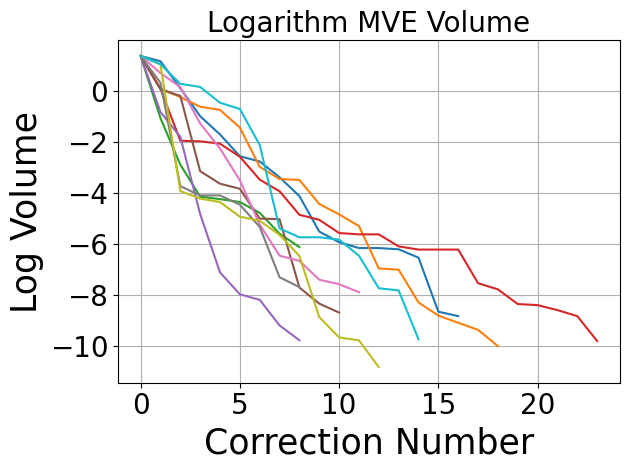

In [6]:
plt.figure()
plt.title("Logarithm MVE Volume",fontsize=20)
plt.ylabel("Log Volume",fontsize=25)
plt.xlabel("Correction Number",fontsize=25)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
for i in range(10):
    plt.plot(np.arange(len(volume_logs[i])),volume_logs[i])
plt.tight_layout()
plt.grid()
#plt.savefig('../Data/pendulum/logdet.png')
plt.show()

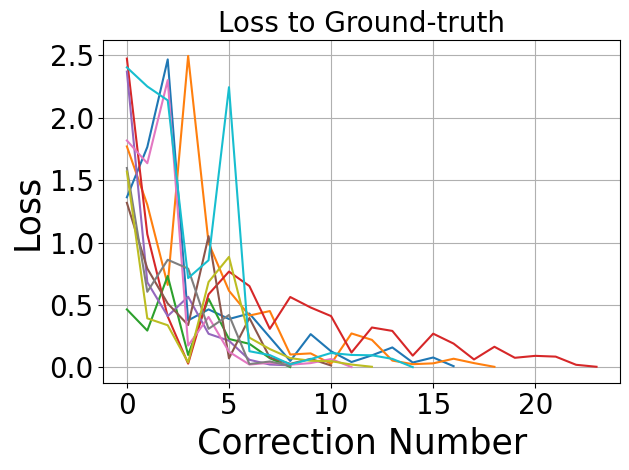

In [7]:
plt.figure()
plt.title("Loss to Ground-truth",fontsize=20)
plt.ylabel("Loss",fontsize=25)
plt.xlabel("Correction Number",fontsize=25)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
for i in range(10):
    plt.plot(np.arange(len(error_logs[i])),error_logs[i])
plt.tight_layout()
plt.grid()
#plt.savefig('../Data/pendulum/loss.png')
plt.show()